# LSTM Multiserie e Multivariada

## Primeira Análise: Modelo LSTM para 1 Trip

### Dataset

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

from sklearn.preprocessing import MinMaxScaler

In [4]:
# Leitura de um arquivo da base https://ieee-dataport.org/open-access/battery-and-heating-data-real-driving-cycles
trip = pd.read_csv("./data/ieee/TripA01.csv", sep=";", encoding='unicode_escape')
trip.head()

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,AirCon Power [kW],Heater Signal,Heater Voltage [V],Heater Current [A],Ambient Temperature [°C],Coolant Temperature Heatercore [°C],Requested Coolant Temperature [°C],Coolant Temperature Inlet [°C],Heat Exchanger Temperature [°C],Cabin Temperature Sensor [°C]
0,0.0,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.20,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
1,0.1,0.0,574.0,0.0,0.0,0.00,0.0,391.4,-2.21,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
2,0.2,0.0,574.0,0.0,0.0,-0.01,0.0,391.4,-2.26,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
3,0.3,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
4,0.4,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5


In [5]:
# Colunas do dataset
trip.columns

Index(['Time [s]', 'Velocity [km/h]', 'Elevation [m]', 'Throttle [%]',
       'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]',
       'Regenerative Braking Signal ', 'Battery Voltage [V]',
       'Battery Current [A]', 'Battery Temperature [°C]',
       'max. Battery Temperature [°C]', 'SoC [%]', 'displayed SoC [%]',
       'min. SoC [%]', 'max. SoC [%)', 'Heating Power CAN [kW]',
       'Heating Power LIN [W]', 'Requested Heating Power [W]',
       'AirCon Power [kW]', 'Heater Signal', 'Heater Voltage [V]',
       'Heater Current [A]', 'Ambient Temperature [°C]',
       'Coolant Temperature Heatercore [°C]',
       'Requested Coolant Temperature [°C]', 'Coolant Temperature Inlet [°C]',
       'Heat Exchanger Temperature [°C]', 'Cabin Temperature Sensor [°C]'],
      dtype='object')

In [6]:
# Análise estatística das variáveis do dataset
trip.describe()

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,AirCon Power [kW],Heater Signal,Heater Voltage [V],Heater Current [A],Ambient Temperature [°C],Coolant Temperature Heatercore [°C],Requested Coolant Temperature [°C],Coolant Temperature Inlet [°C],Heat Exchanger Temperature [°C],Cabin Temperature Sensor [°C]
count,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000,...,10090.000000,10090.0,10090.0,10090.0,10090.000000,10090.0,10090.0,10090.0,10090.000000,10090.000000
mean,504.450000,26.502170,566.791625,26.470424,8.106545,0.014246,0.118162,388.483996,-11.953476,21.940141,...,1.610408,1.0,0.0,0.0,30.769972,0.0,0.0,0.0,8.589470,23.907057
std,291.287644,15.497032,5.577563,16.370510,42.123984,0.741669,0.322172,2.158318,22.799614,0.237147,...,0.340490,0.0,0.0,0.0,1.619032,0.0,0.0,0.0,7.124407,1.249755
min,0.000000,0.000000,558.000000,0.000000,-87.050000,-2.290000,0.000000,380.420000,-100.700000,21.000000,...,0.400000,1.0,0.0,0.0,25.500000,0.0,0.0,0.0,5.000000,22.170000
25%,252.225000,15.362500,562.090000,13.550000,-9.157500,-0.330000,0.000000,387.190000,-22.197500,22.000000,...,1.580000,1.0,0.0,0.0,30.500000,0.0,0.0,0.0,5.000000,22.670000
50%,504.450000,29.550000,565.000000,31.100000,4.630000,0.020000,0.000000,388.540000,-8.570000,22.000000,...,1.670000,1.0,0.0,0.0,31.000000,0.0,0.0,0.0,5.000000,24.000000
75%,756.675000,38.720000,574.000000,40.357500,23.540000,0.350000,0.000000,390.000000,-1.990000,22.000000,...,1.760000,1.0,0.0,0.0,32.000000,0.0,0.0,0.0,7.000000,25.010000
max,1008.900000,53.300000,574.000000,55.900000,174.420000,2.790000,1.000000,394.470000,66.220000,22.000000,...,2.520000,1.0,0.0,0.0,33.500000,0.0,0.0,0.0,30.500000,25.840000


In [7]:
# Verificação por valores nulos
trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10090 entries, 0 to 10089
Data columns (total 28 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Time [s]                             10090 non-null  float64
 1   Velocity [km/h]                      10090 non-null  float64
 2   Elevation [m]                        10090 non-null  float64
 3   Throttle [%]                         10090 non-null  float64
 4   Motor Torque [Nm]                    10090 non-null  float64
 5   Longitudinal Acceleration [m/s^2]    10090 non-null  float64
 6   Regenerative Braking Signal          10090 non-null  float64
 7   Battery Voltage [V]                  10090 non-null  float64
 8   Battery Current [A]                  10090 non-null  float64
 9   Battery Temperature [°C]             10090 non-null  float64
 10  max. Battery Temperature [°C]        10090 non-null  float64
 11  SoC [%]                     

In [8]:
# Ordenação do dataset pelo tempo.
# Como é uma série temporal, é necessário ter certeza de que está ordenado.
trip = trip.sort_values("Time [s]")
trip.head()

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,AirCon Power [kW],Heater Signal,Heater Voltage [V],Heater Current [A],Ambient Temperature [°C],Coolant Temperature Heatercore [°C],Requested Coolant Temperature [°C],Coolant Temperature Inlet [°C],Heat Exchanger Temperature [°C],Cabin Temperature Sensor [°C]
0,0.0,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.20,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
1,0.1,0.0,574.0,0.0,0.0,0.00,0.0,391.4,-2.21,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
2,0.2,0.0,574.0,0.0,0.0,-0.01,0.0,391.4,-2.26,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
3,0.3,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
4,0.4,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5


### Preprocessamento

In [9]:
# As colunas 'Motor Torque [Nm]' e 'Throttle [%]' serão os rótulos de dois modelos diferentes.
# Logo, não posso utilizá-las em nenhum dos X.
# Mantive o tempo pq a variação do tempo pode não ser constante, então pode haver um padrão nele.
# Primeiro teste somente para o Torque.
X = trip.drop(columns=['Motor Torque [Nm]', 'Throttle [%]']).values
y = trip['Motor Torque [Nm]'].values

In [10]:
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

### Janelamento e Treinamento do Modelo

In [12]:
# Primeira construção de um modelo LSTM para avaliar a base
def LSTM_model(data, labels, window_size=10, train_size=0.8, epochs=10):
    """
    Cria o cubo de dados para a entrada da LSTM.
    Divide os dados em treino e validação.
    Monta a arquitetura do LSTM.
    Compila e treina a rede.
    Imprime um gráfico com os dados de validação e treino.

    Args:
        data (pandas.Dataframe): Dados para o treinamento que compõe o X.
        labels (pandas.Series): Lista dos rótulos dos dados que compõe o y.
        window_size (int): Tamanho da janela móvel para o LSTM.
        train_size (float): Tamanho da fatia de dados para o treinamento.
        epochs (int): Número de épocas para o treinamento da rede.

    Returns:
        tensorflow.keras.models.Sequential: Modelo LSTM treinado.
    """
    # Criando o cubo de dados.
    X_seq, y_seq = [], []
    
    for i in range(window_size, len(data)):
        X_seq.append(data[i-window_size:i, :])
        y_seq.append(labels[i])
        
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)

    
    # Divisão de treino e validação.
    train_size = int(len(X_seq) * train_size)
    X_train, X_test = X_seq[:train_size], X_seq[train_size:]
    y_train, y_test = y_seq[:train_size], y_seq[train_size:]


    # Monta, compila e treina o modelo.
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(32, activation='tanh'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=16)


    # Imprimindo o gráfico de treinamento e validação do modelo
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid()

    loss, mae = model.evaluate(X_test, y_test)
    print(f"MAE: {mae:.8f}, Loss: {loss:.8f}")

    return model

Epoch 1/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1385.9805 - mae: 25.5622 - val_loss: 1801.4233 - val_mae: 36.7943
Epoch 2/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 978us/step - loss: 304.3570 - mae: 12.1556 - val_loss: 315.1173 - val_mae: 12.3080
Epoch 3/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 155.4370 - mae: 8.3740 - val_loss: 278.0846 - val_mae: 11.9860
Epoch 4/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 93.5846 - mae: 6.3861 - val_loss: 495.0242 - val_mae: 16.0846
Epoch 5/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 71.0190 - mae: 5.6461 - val_loss: 394.8571 - val_mae: 13.9083
Epoch 6/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 60.7561 - mae: 5.0487 - val_loss: 291.9001 - val_mae: 13.5750
Epoch 7/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 48.8695 - mae: 4.6866 - val_loss: 563.3698 - val_mae: 16.5134
Epoch 8/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 40.3839 - mae: 4.1593 - val_loss: 445.0995 - val_mae: 14.7567
Epo

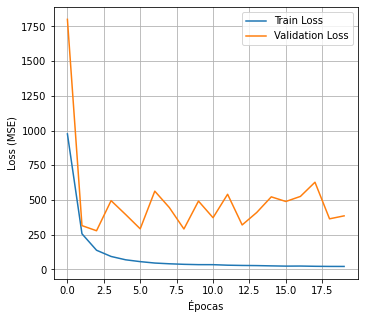

In [15]:
# Treinando um primeiro modelo de Torque somente para a TripA01
model = LSTM_model(X_scaled, y, window_size=10, train_size=0.8, epochs=20)

## Segunda Análise: Modelo LSTM para N Trips

### Preparação do Dataset

In [32]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

import matplotlib.pyplot as plt

In [10]:
# Definição do diretório aonde estão os arquivos do dataset https://ieee-dataport.org/open-access/battery-and-heating-data-real-driving-cycles
# Os arquivos irão entrar para o treinamento na ordem alfabética.
directory = "./data/ieee/"
files = os.listdir(directory)
files.sort()


# Lendo cada um dos arquivos das trips do dataset, ordenando pelo tempo.
# Todos os datasets lidos ficarão em uma lista de pandas.DataFrames.
# Observe que eu adiciono uma coluna chamada Trip que tem o nome do arquivo sem a extensão dele.
# Isso será importante para saber de onde veio cada registro depois.
trips = []
for file in files:
    trip = pd.read_csv(directory + file, sep=";", encoding='unicode_escape')
    trip = trip.sort_values(by='Time [s]')
    trip['Trip'] = file.split(".")[0]
    trips.append(trip)


# Criando uma lista de lista de colunas das trips.
# A ideia aqui é verificar as colunas comuns a todas as trips para ter a indicação do que podemos utilizar.
columns = []
for trip in trips:
    # Há arquivos que o nome da coluna velocidade está com a grafia errada.
    # Nesse caso, precisa fazer o mapeamento para a grafia correta para evitar NaN na coluna.
    if 'Velocity [km/h]]]' in trip.columns:
        trip = trip.rename(columns={'Velocity [km/h]]]': 'Velocity [km/h]'})
        print(trip['Trip'].unique())    # Imprimindo as trips que estão com a grafia errada
        
    columns.append(trip.columns.tolist())


# Retira os grupos de colunas repetidos.
# Nesse caso, ficamos com os grupos de colunas únicos.
grupo_colunas_unicos = [list(x) for x in set(tuple(lst) for lst in columns)]
grupo_colunas_unicos

['TripB38']


[['Time [s]',
  'Velocity [km/h]',
  'Elevation [m]',
  'Throttle [%]',
  'Motor Torque [Nm]',
  'Longitudinal Acceleration [m/s^2]',
  'Regenerative Braking Signal ',
  'Battery Voltage [V]',
  'Battery Current [A]',
  'Battery Temperature [°C]',
  'max. Battery Temperature [°C]',
  'SoC [%]',
  'displayed SoC [%]',
  'min. SoC [%]',
  'max. SoC [%)',
  'Heating Power CAN [kW]',
  'Heating Power LIN [W]',
  'Requested Heating Power [W]',
  'AirCon Power [kW]',
  'Heater Signal',
  'Heater Voltage [V]',
  'Heater Current [A]',
  'Ambient Temperature [°C]',
  'Coolant Temperature Heatercore [°C]',
  'Requested Coolant Temperature [°C]',
  'Coolant Temperature Inlet [°C]',
  'Heat Exchanger Temperature [°C]',
  'Cabin Temperature Sensor [°C]',
  'Trip'],
 ['Time [s]',
  'Velocity [km/h]',
  'Elevation [m]',
  'Throttle [%]',
  'Motor Torque [Nm]',
  'Longitudinal Acceleration [m/s^2]',
  'Regenerative Braking Signal ',
  'Battery Voltage [V]',
  'Battery Current [A]',
  'Battery Temperat

In [11]:
# Analisando a lista de grupos de colunas.
# A ideia é pegar todas as colunas diferentes que aparecem nos 5 grupos de colunas que encontramos nos arquivos
total_columns = grupo_colunas_unicos[0]

# Passa por todos os grupos pegando todas as colunas que ainda não são conhecidas.
for group in grupo_colunas_unicos:
    for column in group:
        if column not in total_columns:
            total_columns.append(column)

# Temos 50 colunas diferentes em 5 grupos.
print(len(total_columns))
total_columns.sort()
total_columns

50


['AirCon Power [kW]',
 'Ambient Temperature Sensor [°C]',
 'Ambient Temperature [°C]',
 'Battery Current [A]',
 'Battery Temperature [°C]',
 'Battery Voltage [V]',
 'Cabin Temperature Sensor [°C]',
 'Coolant Temperature Heatercore [°C]',
 'Coolant Temperature Inlet [°C]',
 'Coolant Volume Flow +500 [l/h]',
 'Elevation [m]',
 'Heat Exchanger Temperature [°C]',
 'Heater Current [A]',
 'Heater Signal',
 'Heater Voltage [V]',
 'Heating Power CAN [kW]',
 'Heating Power LIN [W]',
 'Longitudinal Acceleration [m/s^2]',
 'Motor Torque [Nm]',
 'Regenerative Braking Signal ',
 'Requested Coolant Temperature [°C]',
 'Requested Heating Power [W]',
 'SoC [%]',
 'Temperature Coolant Heater Inlet [°C]',
 'Temperature Coolant Heater Outlet [°C]',
 'Temperature Defrost central [°C]',
 'Temperature Defrost central left [°C]',
 'Temperature Defrost central right [°C]',
 'Temperature Defrost lateral left [°C]',
 'Temperature Defrost lateral right [°C]',
 'Temperature Feetvent Co-Driver [°C]',
 'Temperature

In [12]:
# A ideia aqui é pegar o grupo de colunas que seja comum aos 5 grupos que identificamos nas trips
# Crio um set com apenas um elemento que é o primeiro grupo.
colunas_comuns = set(grupo_colunas_unicos[0])

# Começando do segundo grupo, eu faço a interseção dos sets até que se atinja o último grupo.
for item in grupo_colunas_unicos[1:]:
    colunas_comuns.intersection_update(item)

# Retorno de set para list e ordeno para saber as colunas que poderemos usar por estar em todas os arquivos de Trips.
colunas_comuns = list(colunas_comuns)
colunas_comuns.sort()
colunas_comuns

['AirCon Power [kW]',
 'Ambient Temperature [°C]',
 'Battery Current [A]',
 'Battery Temperature [°C]',
 'Battery Voltage [V]',
 'Cabin Temperature Sensor [°C]',
 'Elevation [m]',
 'Heat Exchanger Temperature [°C]',
 'Heater Signal',
 'Heating Power CAN [kW]',
 'Longitudinal Acceleration [m/s^2]',
 'Motor Torque [Nm]',
 'Regenerative Braking Signal ',
 'Requested Heating Power [W]',
 'SoC [%]',
 'Throttle [%]',
 'Time [s]',
 'Trip',
 'Velocity [km/h]',
 'displayed SoC [%]',
 'max. Battery Temperature [°C]',
 'max. SoC [%)',
 'min. SoC [%]']

In [13]:
# Lista de colunas exclusivas de carros elétricos que qualquer dataset de combustão não terá
colunas_remover = [
    'Battery Current [A]',
    'Battery Temperature [°C]',
    'Battery Voltage [V]',
    'Regenerative Braking Signal ',
    'SoC [%]',
    'displayed SoC [%]',
    'max. Battery Temperature [°C]',
    'max. SoC [%)',
    'min. SoC [%]'
]

# Removendo as colunas exclusivas de elétrico, ordenando e imprimindo.
colunas_final = [item for item in colunas_comuns if item not in colunas_remover]
colunas_final.sort()
colunas_final

['AirCon Power [kW]',
 'Ambient Temperature [°C]',
 'Cabin Temperature Sensor [°C]',
 'Elevation [m]',
 'Heat Exchanger Temperature [°C]',
 'Heater Signal',
 'Heating Power CAN [kW]',
 'Longitudinal Acceleration [m/s^2]',
 'Motor Torque [Nm]',
 'Requested Heating Power [W]',
 'Throttle [%]',
 'Time [s]',
 'Trip',
 'Velocity [km/h]']

In [14]:
# Concatenando todos os datasets lidos dos arquivos das trips que estvam em uma lista.
# A partir daqui o trips deixa de ser uma list e passa a ser um pandas.DataFrame.
# Eu sei que manter o mesmo nome da variável e trocar o tipo não é legal.
trips = pd.concat(trips)
trips = trips[colunas_final]
trips.shape

(1094793, 14)

In [15]:
# Visualizando os valores possíveis da coluna Trip que eu criei com o nome dos arquivos na leitura
trips['Trip'].unique()

array(['TripA01', 'TripA02', 'TripA03', 'TripA04', 'TripA05', 'TripA06',
       'TripA07', 'TripA08', 'TripA09', 'TripA10', 'TripA11', 'TripA12',
       'TripA13', 'TripA14', 'TripA15', 'TripA16', 'TripA17', 'TripA18',
       'TripA19', 'TripA20', 'TripA21', 'TripA22', 'TripA23', 'TripA24',
       'TripA25', 'TripA26', 'TripA27', 'TripA28', 'TripA29', 'TripA30',
       'TripA31', 'TripA32', 'TripB01', 'TripB02', 'TripB03', 'TripB04',
       'TripB05', 'TripB06', 'TripB07', 'TripB08', 'TripB09', 'TripB10',
       'TripB11', 'TripB12', 'TripB13', 'TripB14', 'TripB15', 'TripB16',
       'TripB17', 'TripB18', 'TripB19', 'TripB20', 'TripB21', 'TripB22',
       'TripB23', 'TripB24', 'TripB25', 'TripB26', 'TripB27', 'TripB28',
       'TripB29', 'TripB30', 'TripB31', 'TripB32', 'TripB33', 'TripB34',
       'TripB35', 'TripB36', 'TripB37', 'TripB38'], dtype=object)

In [17]:
# Novamente retiro os labels que vou prever (torque e throttle).
# Preciso remover a coluna de Trip que eu coloquei pq ela não é um dado do dataset e está como texto.
# Se eu quisesse utilizá-la, deveria passá-la para número, mas sem ter ordem, o que me leva a um getdummies.
# O y para essa primeira rodada é somente o torque.
X = trips.drop(columns=['Motor Torque [Nm]', 'Throttle [%]', 'Trip'])
y = trips['Motor Torque [Nm]'].values    # Aqui já vem um numpy.array que será usado na normalização

In [18]:
# Normalização do X e do y.
# Observe que o X tem várias colunas na normalização. Essa informação é importante na hora de desnormalizar.
# O scaler gerado aqui vai esperar o mesmo número de colunas que tenho agora para poder fazer a desnormalização.
# Isso é usado lá na frente na hora de plotar o timeline.
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# O meu X é um pandas.DataFrame que eu pego os values e vira um numpy.array.
# O y já é um numpy.array e eu só preciso acertar o shape que ele tinha perdido.
X_scaled = scaler_X.fit_transform(X.values)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [19]:
# Aqui estou remontando o meu pandas.DataFrame após a normalização.
# Eu trago de volta os nomes das colunas, os índices e a coluna que Trip que identifica de onde veio o registro.
X_scaled = pd.DataFrame(
    X_scaled,
    columns=X.columns,
    index=X.index
)
X_scaled['Trip'] = trips['Trip']
X_scaled.head()

,AirCon Power [kW],Ambient Temperature [°C],Cabin Temperature Sensor [°C],Elevation [m],Heat Exchanger Temperature [°C],Heater Signal,Heating Power CAN [kW],Longitudinal Acceleration [m/s^2],Requested Heating Power [W],Time [s],Velocity [km/h],Trip
0,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.667161,0.002206,0.000000,0.0,TripA01
1,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.669385,0.002206,0.000018,0.0,TripA01
2,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.668643,0.002206,0.000036,0.0,TripA01
3,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.667161,0.002206,0.000053,0.0,TripA01
4,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.667161,0.002206,0.000071,0.0,TripA01


In [21]:
# Trazendo o y de volta para o dataset.
# Nesse momento, eu tenho um dataset igual ao original, porém normalizado
scaled_dataset = X_scaled
scaled_dataset['Motor Torque [Nm]'] = y_scaled
scaled_dataset.head()

,AirCon Power [kW],Ambient Temperature [°C],Cabin Temperature Sensor [°C],Elevation [m],Heat Exchanger Temperature [°C],Heater Signal,Heating Power CAN [kW],Longitudinal Acceleration [m/s^2],Requested Heating Power [W],Time [s],Velocity [km/h],Trip,Motor Torque [Nm]
0,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.667161,0.002206,0.000000,0.0,TripA01,0.260522
1,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.669385,0.002206,0.000018,0.0,TripA01,0.260522
2,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.668643,0.002206,0.000036,0.0,TripA01,0.260522
3,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.667161,0.002206,0.000053,0.0,TripA01,0.260522
4,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.667161,0.002206,0.000071,0.0,TripA01,0.260522


In [22]:
def time_series_train_test_split(dataset, id_column, train_size=0.8):
    """
    Para séries temporais, a divisão em treino e teste precisa levar em consideração o tempo.
    Por exemplo, pego os 80% primeiros registros e vou testar contra os 20% finais.
    Essa função recebe um dataset com N séries temporais, definidas na coluna identificadora e realiza o split para cada uma delas.

    Args:
        dataset (pandas.DataFrame): Dataset contendo N séries temporais, com uma coluna identificadora.
        id_column (string): Nome da coluna que guarda a identificação de cada uma das séries temporais.
        train_size (float): Tamanho da fatia de dados para o treinamento.

    Returns:
        X_train (pandas.DataFrame): Dataframe com os X das N séries para treino.
        X_test (pandas.DataFrame): Dataframe com os X das N séries para test.
        y_train (pandas.DataFrame): Dataframe com os y das N séries para treino.
        y_test (pandas.DataFrame): Dataframe com os y das N séries para test.
    """
    # Listas para guardar os slices de DataFrames referentes aos retornos no final
    X_trains, X_tests, y_trains, y_tests = [], [], [], []

    # Passa por todas as trips diferentes que tem na coluna identificadora.
    for trip in dataset[id_column].unique():
        # Pega uma trip e calcula o número de registros que ficarão para treino
        data_slice = dataset[dataset[id_column] == trip]
        size = int(len(data_slice) * train_size)

        # Realiza o slices do X treino e teste
        X_trains.append(data_slice.iloc[:size, :-1])
        X_tests.append(data_slice.iloc[size:, :-1])

        # Realiza os slices do y treino e teste
        y_trains.append(data_slice.iloc[:size, -1])
        y_tests.append(data_slice.iloc[size:, -1])

    # Concatena os conteúdos de cada uma das listas e retorna os pandas.DataFrames
    return pd.concat(X_trains), pd.concat(X_tests), pd.concat(y_trains), pd.concat(y_tests)

# Execução da função no dataset normalizado, passando a coluna Trip como identificadora das trips
X_train, X_test, y_train, y_test = time_series_train_test_split(scaled_dataset, 'Trip')

In [25]:
# Visualizando os shapes dos DataFrames divididos.
# É interessante observar o número de linhas dos Xs para os y e ver se obedece o pedido na célula anterior.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(875810, 12)
(218983, 12)
(875810,)
(218983,)


In [28]:
def create_seq(X, y, id_column, window_size=10):
    """
    O LSTM precisa de um cubo de dados adicionando a dimensão tamanho da janela.
    Ou seja, inicialmente eu tenho linhas (registros) e colunas (features), eu preciso fazer uma 
    lista de conjuntos de registros do tamanho do window_size. Nesse caso, terei uma dimensão para
    escolher qual o conjunto na lista, uma dimensão para saber qual a linha no conjunto e uma dimensão
    para saber qual a coluna. Esse será o cubo de dados em numpy.array.

    Args:
        X (pandas.DataFrame): Dataset contendo o X de N séries temporais, com uma coluna identificadora.
        y (pandas.Series): Série contendo o y de N séries temporais.
        id_column (string): Nome da coluna que guarda a identificação de cada uma das séries temporais.
        window_size (int): Tamanho da janela que será usada no LSTM.

    Returns:
        X_seq (numpy.array): Cubo de dados dos X obtidos.
        y_seq (numpy.array): Array com os y relativos ao X_seq.
    """
    # Listas para guardar os resultados de cada uma das séries temporais
    X_seq, y_seq = [], []

    # Loop que inicia no tamanho da janela e vai até o tamanho de X
    for i in range(window_size, len(X)):
        # Recorte da janela. Obserque vai de i - janela até i, ou seja, do tamanho da janela.
        # Pega todas as colunas.
        data_slice = X.iloc[i-window_size:i, :]

        # Se tiver mais de uma trip na mesma janela, eu não adiciono no conjunto de dados
        # Não faz sentido janelas que começam no final de uma trip e tem dados do início de outra.
        if len(data_slice[id_column].unique()) == 1:
            X_seq.append(data_slice.drop(columns=[id_column]).values)    # Adiciono o slice que eu fiz, dropando a coluna identificadora e passando para numpy.array
            y_seq.append(y[i])    # Pego o y referente ao último registro da janela.
        
    return np.array(X_seq), np.array(y_seq)    # Retorno os numpy.arrays que são a concatenação de todas as trips.


# Chamando a criação do cubo para os dados de treino
X_train_seq, y_train_seq = create_seq(X_train, y_train.values, 'Trip', window_size=10)

# Chamando a criação do cubo para os dados de teste
X_test_seq, y_test_seq = create_seq(X_test, y_test.values, 'Trip', window_size=10)

In [29]:
# A célula anterior demora para executar. É natural que tente-se salvar o resultado e carregar o cubo posteriormente.
# No entanto, não deve-se usar isso aqui para salvar pq está perdendo o shape.
# Talvez se guardar o shape e usar um reshape depois funcione.

# X_train_seq.tofile('./X_train_seq.dat')
# y_train_seq.tofile('./y_train_seq.dat')
# X_test_seq.tofile('./X_test_seq.dat')
# y_test_seq.tofile('./y_test_seq.dat')

# X_train_seq = np.fromfile('./X_train_seq.dat')
# y_train_seq = np.fromfile('./y_train_seq.dat')
# X_test_seq = np.fromfile('./X_test_seq.dat')
# y_test_seq = np.fromfile('./y_test_seq.dat')

### Treinamento do LSTM

In [30]:
def LSTM_model(X_seq, y_seq, window_size=10, train_size=0.8, epochs=10):
    """
    Divide os dados em treino e validação.
    Monta a arquitetura do LSTM.
    Compila e treina a rede.
    Imprime um gráfico com os dados de validação e treino.

    Args:
        X_seq (numpy.array): Cubo de dados para o treinamento que compõe o X.
        y_seq (numpy.array): Rótulos referentes ao cubo de dados que compõe o y.
        window_size (int): Tamanho da janela móvel para o LSTM.
        train_size (float): Tamanho da fatia de dados para o treinamento.
        epochs (int): Número de épocas para o treinamento da rede.

    Returns:
        tensorflow.keras.models.Sequential: Modelo LSTM treinado.
    """
    # Divisão de treino e validação.
    train_size = int(len(X_seq) * train_size)
    X_train, X_test = X_seq[:train_size], X_seq[train_size:]
    y_train, y_test = y_seq[:train_size], y_seq[train_size:]


    # Monta, compila e treina o modelo.
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(32, activation='tanh'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=16)


    # Imprimindo o gráfico de treinamento e validação do modelo
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid()

    loss, mae = model.evaluate(X_test, y_test)
    print(f"MAE: {mae:.8f}, Loss: {loss:.8f}")

    return model

Epoch 1/20
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 49s 1ms/step - loss: 0.0013 - mae: 0.0212 - val_loss: 0.0070 - val_mae: 0.0343
Epoch 2/20
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 52s 1ms/step - loss: 3.7747e-04 - mae: 0.0133 - val_loss: 0.0049 - val_mae: 0.0281
Epoch 3/20
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 54s 1ms/step - loss: 3.4545e-04 - mae: 0.0126 - val_loss: 0.0042 - val_mae: 0.0274
Epoch 4/20
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - loss: 3.2912e-04 - mae: 0.0122 - val_loss: 0.0038 - val_mae: 0.0250
Epoch 5/20
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - loss: 3.1628e-04 - mae: 0.0119 - val_loss: 0.0035 - val_mae: 0.0249
Epoch 6/20
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - loss: 3.0727e-04 - mae: 0.0117 - val_loss: 0.0031 - val_mae: 0.0229
Epoch 7/20
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - loss: 2.9320e-04 - mae: 0.0115 - val_loss: 0.0028 - val_mae: 0.0220
Epoch 8/20
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 54s 1ms/step - loss: 2.8693e-04 - mae: 0.0113 - val_loss: 0.0026 - val_

<Sequential name=sequential_1, built=True>

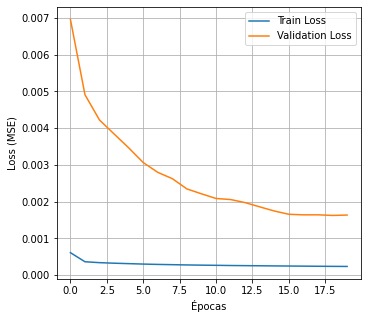

In [33]:
# Treinando um segundo modelo de Torque para N trips
model = LSTM_model(X_train_seq, y_train_seq, window_size=10, train_size=0.8, epochs=20)
model

In [34]:
# Imprimindo o sumário do modelo LSTM treinado
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,165 (78.77 KB)

 Trainable params: 6,721 (26.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,444 (52.52 KB)

### Avaliação 

In [35]:
def plot_error_histogram(y_pred, y_test):
    """
    Plota um histograma do erro do modelo.

    Args:
        y_pred (numpy.array): Valores preditos por um modelo.
        y_test (numpy.array): Valores reais equivalentes aos preditos.
    """
    # Erro é o y predito menos o y real
    error = y_pred - y_test

    # Estatísticas do erro
    mean_error = np.mean(error)
    std_error = np.std(error)
    min_error = np.min(error)
    max_error = np.max(error)

    # Histograma
    plt.hist(error, bins=50, color='blue', alpha=0.7, edgecolor='black')

    # Linhas de referência
    plt.axvline(mean_error, color='red', linestyle='dashed', linewidth=2, label=f"Média: {mean_error:.4f}")
    plt.axvline(mean_error + 2*std_error, color='green', linestyle='dashed', linewidth=2, label=f'+2σ: {(mean_error + 2*std_error):.4f}')
    plt.axvline(mean_error - 2*std_error, color='green', linestyle='dashed', linewidth=2, label=f'-2σ: {(mean_error - 2*std_error):.4f}')
    plt.axvline(min_error, color='purple', linestyle='dashed', linewidth=2, label=f'Mínimo: {min_error:.4f}')
    plt.axvline(max_error, color='orange', linestyle='dashed', linewidth=2, label=f'Máximo: {max_error:.4f}')

    # Configurações do gráfico
    plt.xlabel("Erro (y_pred - y_real)")
    plt.ylabel("Frequência")
    plt.legend()
    plt.grid(True)

    # Exibição 
    plt.show()

6824/6824 ━━━━━━━━━━━━━━━━━━━━ 4s 544us/step


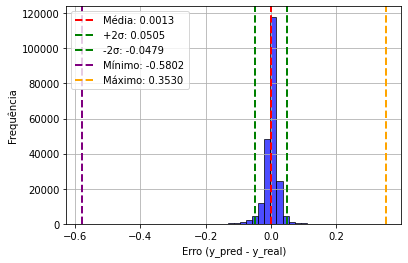

In [36]:
# Realizando a predição com o modelo treinado
prediction = model.predict(X_test_seq)

# Fazendo o reshape do numpy.array para poder ficar equivalente ao y_test_seq
y_pred_seq = prediction.reshape(1,-1)[0]

# Plotando o histograma do erro
plot_error_histogram(y_pred_seq, y_test_seq)

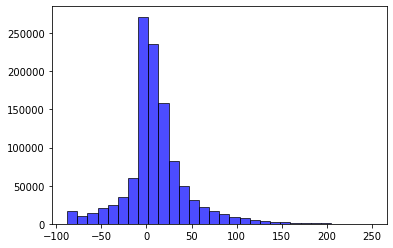

In [37]:
# Plotando um histograma dos valores do torque para saber se o gráfico anterior é significativo.
# No entanto, o gráfico anterior está normalizado e este aqui não está.
# Acaba que não dá para fazer a comparação. No entanto, como esse gráfico é refeito mais adiante atendendo essa parte da normalização,
# não vou mexer nessa parte aqui.
plt.hist(trips['Motor Torque [Nm]'], bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.show()

## Terceira Análise: Modelo Torque e Throttle Finais

### General Functions

In [1]:
# Esse export é para retirar um warning do tensorflow, não precisa se importar com isso aqui.
!export TF_ENABLE_ONEDNN_OPTS=0

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from IPython.display import display


WINDOW_SIZE = 10

In [4]:
# Definição do diretório aonde estão os arquivos do dataset https://ieee-dataport.org/open-access/battery-and-heating-data-real-driving-cycles
# Os arquivos irão entrar para o treinamento na ordem alfabética.
directory = "./data/ieee/"
files = os.listdir(directory)
files.sort()


# Lendo cada um dos arquivos das trips do dataset, ordenando pelo tempo.
# Todos os datasets lidos ficarão em uma lista de pandas.DataFrames.
# Observe que eu adiciono uma coluna chamada Trip que tem o nome do arquivo sem a extensão dele.
# Isso será importante para saber de onde veio cada registro depois.
# Já resolvo o problema de grafia errada da velocidade em um dos arquivos do dataset.
trips = []
for file in files:
    trip = pd.read_csv(directory + file, sep=";", encoding='unicode_escape')
    trip = trip.sort_values(by='Time [s]')
    trip['Trip'] = file.split(".")[0]
    if 'Velocity [km/h]]]' in trip.columns:
        trip = trip.rename(columns={'Velocity [km/h]]]': 'Velocity [km/h]'})
    trips.append(trip)


# Estou utilizando somente as colunas do dataset que possuem uma equivalente no dataset de combustão que o Daniel me enviou.
# A seguir tem um mapa das variáveis no elétrico para as variáveis no dataset de combustão. Isso será importante para a segunda 
# etapa do projeto de emissões de CO2.

# Mapa:
# 'Ambient Temperature [°C]': 'Veh_ambient_temp_ECM',
# 'Cabin Temperature Sensor [°C]': 'HVAC_pass_compartment_air_temp_filt_HVAC',
# 'Heat Exchanger Temperature [°C]': 'HVAC_heater_core_coolant_temp_sensor_HVAC',
# 'Longitudinal Acceleration [m/s^2]': 'ActVehAccel',
# 'Throttle [%]': 'Eng_throttle_pos_ECM',
# 'Velocity [km/h]': 'VehSpdAvgDrvn'

# Colunas selecionadas do elétrico por ter equivalente no combustão.
colunas_selecionadas = [
    'Ambient Temperature [°C]',
    'Cabin Temperature Sensor [°C]',
    'Heat Exchanger Temperature [°C]',
    'Longitudinal Acceleration [m/s^2]',
    'Throttle [%]',
    'Velocity [km/h]',
    'Motor Torque [Nm]',
    'Time [s]',
    'Trip'
]


# Concatenando todas as trips lidas e selecionando as colunas indicadas.
trips = pd.concat(trips)
trips = trips[colunas_selecionadas]
trips.shape

(1094793, 9)

In [5]:
def normalize(data, label):
    """
    Realiza a normalização dos dados.

    Args:
        data (pandas.DataFrame): Dataset com os dados que serão normalizados.
        label (string): Nome da coluna que será o rótulo.

    Returns:
        scaled_dataset (pandas.DataFrame): Dataset incial normalizado.
        scaler_X (sklearn.preprocessing.MinMaxScaler): Normalizador e desnormalizador do X.
        scaler_y (sklearn.preprocessing.MinMaxScaler): Normalizador e desnormalizador do y.
    """
    # Colunas que serão utilizadas no X.
    # Estou deixando 'Time [s]' no X pq os intervalos de tempo não são regulares
    columns = ['Trip', 'Throttle [%]', 'Motor Torque [Nm]']

    # Separação do X e do y para normalizar
    X = data.drop(columns=columns)
    y = data[label].values

    # Criação dos scalers
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Normalização
    X_scaled = scaler_X.fit_transform(X.values)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    # Remontagem do pandas.DataFrame original só que normalizado.
    # Eu retorno o nome das colunas, os índices, a coluna que identifica a viagem que gerou o registro e o y.
    X_scaled = pd.DataFrame(
        X_scaled,
        columns=X.columns,
        index=X.index
    )
    X_scaled['Trip'] = data['Trip']
    scaled_dataset = X_scaled
    scaled_dataset[label] = y_scaled

    # Retorno da função
    return scaled_dataset, scaler_X, scaler_y

In [6]:
def time_series_train_test_split(dataset, label, id_column, train_size=0.8):
    """
    Realiza a divisão de treino e teste de N séries temporais.

    Args:
        dataset (pandas.DataFrame): Dataset com os dados que serão divididos.
        label (string): Nome da coluna que será o rótulo y.
        id_column (string): Nome da coluna que tem o identificador das trips.
        train_size (float): Tamanho da fatia de dados para o treinamento.

    Returns:
        X_train (pandas.DataFrame): Dataframe com os X das N séries para treino.
        X_test (pandas.DataFrame): Dataframe com os X das N séries para test.
        y_train (pandas.DataFrame): Dataframe com os y das N séries para treino.
        y_test (pandas.DataFrame): Dataframe com os y das N séries para test.
    """
    # Listas para guardar os slices de DataFrames referentes aos retornos no final
    X_trains, X_tests, y_trains, y_tests = [], [], [], []    

    # Passa por todas as trips diferentes que tem na coluna identificadora.
    for trip in dataset[id_column].unique():
        # Pega uma trip e calcula o número de registros que ficarão para treino
        data_slice = dataset[dataset[id_column] == trip]
        size = int(len(data_slice) * train_size)

        # Realiza o slices do X treino e teste
        X_trains.append(data_slice.drop(columns=[label]).iloc[:size, :])
        X_tests.append(data_slice.drop(columns=[label]).iloc[size:, :])

        # Realiza os slices do y treino e teste
        y_trains.append(data_slice[label].iloc[:size])
        y_tests.append(data_slice[label].iloc[size:])

    # Concatena os conteúdos de cada uma das listas e retorna os pandas.DataFrames
    return pd.concat(X_trains), pd.concat(X_tests), pd.concat(y_trains), pd.concat(y_tests)

In [7]:
def create_seq(X, y, id_column, window_size=10):
    """
    O LSTM precisa de um cubo de dados adicionando a dimensão tamanho da janela.
    Ou seja, inicialmente eu tenho linhas (registros) e colunas (features), eu preciso fazer uma 
    lista de conjuntos de registros do tamanho do window_size. Nesse caso, terei uma dimensão para
    escolher qual o conjunto na lista, uma dimensão para saber qual a linha no conjunto e uma dimensão
    para saber qual a coluna. Esse será o cubo de dados em numpy.array.

    Args:
        X (pandas.DataFrame): Dataset contendo o X de N séries temporais, com uma coluna identificadora.
        y (pandas.Series): Série contendo o y de N séries temporais.
        id_column (string): Nome da coluna que guarda a identificação de cada uma das séries temporais.
        window_size (int): Tamanho da janela que será usada no LSTM.

    Returns:
        X_seq (numpy.array): Cubo de dados dos X obtidos.
        y_seq (numpy.array): Array com os y relativos ao X_seq.
    """
    # Listas para guardar os resultados de cada uma das séries temporais
    X_seq, y_seq = [], []

    # Loop que inicia no tamanho da janela e vai até o tamanho de X
    for i in range(window_size, len(X)):
        # Recorte da janela. Obserque vai de i - janela até i, ou seja, do tamanho da janela.
        # Pega todas as colunas.
        data_slice = X.iloc[i-window_size:i, :]

        # Se tiver mais de uma trip na mesma janela, eu não adiciono no conjunto de dados
        # Não faz sentido janelas que começam no final de uma trip e tem dados do início de outra.
        if len(data_slice[id_column].unique()) == 1:
            X_seq.append(data_slice.drop(columns=[id_column]).values)    # Adiciono o slice que eu fiz, dropando a coluna identificadora e passando para numpy.array
            y_seq.append(y[i])    # Pego o y referente ao último registro da janela.
        
    return np.array(X_seq), np.array(y_seq)    # Retorno os numpy.arrays que são a concatenação de todas as trips.

In [8]:
def LSTM_model(X_seq, y_seq, train_size=0.8, epochs=10, batch_size=16):
    """
    Divide os dados em treino e validação.
    Monta a arquitetura do LSTM.
    Compila e treina a rede.
    Imprime um gráfico com os dados de validação e treino.

    Args:
        X_seq (numpy.array): Cubo de dados para o treinamento que compõe o X.
        y_seq (numpy.array): Rótulos referentes ao cubo de dados que compõe o y.
        train_size (float): Tamanho da fatia de dados para o treinamento.
        epochs (int): Número de épocas para o treinamento da rede.
        batch_size (int): Número de registros que serão utilizados no batch do treinamento. Se pequeno pode impactar na performance.

    Returns:
        tensorflow.keras.models.Sequential: Modelo LSTM treinado.
    """
    # Divisão de treino e validação.
    train_size = int(len(X_seq) * train_size)
    X_train, X_test = X_seq[:train_size], X_seq[train_size:]
    y_train, y_test = y_seq[:train_size], y_seq[train_size:]


    # Monta, compila e treina o modelo.
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(32, activation='tanh'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)


    # Imprimindo o gráfico de treinamento e validação do modelo
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid()

    loss, mae = model.evaluate(X_test, y_test)
    print(f"MAE: {mae:.8f}, Loss: {loss:.8f}")

    return model

In [9]:
def plot_error_histogram(y_pred, y_test, bins=50, color='blue'):
    """
    Plota um histograma do erro do modelo.

    Args:
        y_pred (numpy.array): Valores preditos por um modelo.
        y_test (numpy.array): Valores reais equivalentes aos preditos.
    """
    # Erro é o y predito menos o y real
    error = y_pred - y_test

    # Estatísticas do erro
    mean_error = np.mean(error)
    std_error = np.std(error)
    min_error = np.min(error)
    max_error = np.max(error)

    # Histograma
    plt.hist(error, bins=bins, color=color, alpha=0.7, edgecolor='black')

    # Linhas de referência
    plt.axvline(mean_error, color='red', linestyle='dashed', linewidth=2, label=f"Média: {mean_error:.4f}")
    plt.axvline(mean_error + 2*std_error, color='green', linestyle='dashed', linewidth=2, label=f'+2σ: {(mean_error + 2*std_error):.4f}')
    plt.axvline(mean_error - 2*std_error, color='green', linestyle='dashed', linewidth=2, label=f'-2σ: {(mean_error - 2*std_error):.4f}')
    plt.axvline(min_error, color='purple', linestyle='dashed', linewidth=2, label=f'Mínimo: {min_error:.4f}')
    plt.axvline(max_error, color='orange', linestyle='dashed', linewidth=2, label=f'Máximo: {max_error:.4f}')

    # Configurações do gráfico
    plt.xlabel("Erro (y_pred - y_real)")
    plt.ylabel("Frequência")
    plt.legend()
    plt.grid(True)

    # Exibição 
    plt.show()

### Torque

In [11]:
# Visualizando o dataset original limpo, com colunas selecionadas, ordenado e concatenado. 
# Pronto para o trabalho.
# Foi lido no início dessa terceira análise.
trips.head()

,Ambient Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Longitudinal Acceleration [m/s^2],Throttle [%],Velocity [km/h],Motor Torque [Nm],Time [s],Trip
0,25.5,24.5,30.5,-0.03,0.0,0.0,0.0,0.0,TripA01
1,25.5,24.5,30.5,0.00,0.0,0.0,0.0,0.1,TripA01
2,25.5,24.5,30.5,-0.01,0.0,0.0,0.0,0.2,TripA01
3,25.5,24.5,30.5,-0.03,0.0,0.0,0.0,0.3,TripA01
4,25.5,24.5,30.5,-0.03,0.0,0.0,0.0,0.4,TripA01


In [12]:
# Normalizando o dataset com a coluna torque como rótulo
torque_scaled_dataset, torque_X_scaler, torque_y_scaler = normalize(trips, 'Motor Torque [Nm]')
torque_scaled_dataset.head()

,Ambient Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Longitudinal Acceleration [m/s^2],Velocity [km/h],Time [s],Trip,Motor Torque [Nm]
0,0.783784,0.485904,0.424646,0.667161,0.0,0.000000,TripA01,0.260522
1,0.783784,0.485904,0.424646,0.669385,0.0,0.000018,TripA01,0.260522
2,0.783784,0.485904,0.424646,0.668643,0.0,0.000036,TripA01,0.260522
3,0.783784,0.485904,0.424646,0.667161,0.0,0.000053,TripA01,0.260522
4,0.783784,0.485904,0.424646,0.667161,0.0,0.000071,TripA01,0.260522


In [13]:
# Realizando a divisão de treino e teste para o torque.
# A impressão mostra o head de cada um dos datasets produzidos com os seus respectivos shapes para comparar as proporções.
# Por padrão é 80-20, mas pode trocar no parâmetro da função
torque_X_train, torque_X_test, torque_y_train, torque_y_test = time_series_train_test_split(torque_scaled_dataset, 'Motor Torque [Nm]', 'Trip')
print(f"\ntorque_X_train: {torque_X_train.shape}")
display(torque_X_train.head())

print(f"\ntorque_X_test: {torque_X_test.shape}")
display(torque_X_test.head())

print(f"\ntorque_y_train: {torque_y_train.shape}")
display(torque_y_train.head())

print(f"\ntorque_y_test: {torque_y_test.shape}")
display(torque_y_test.head())


torque_X_train: (875810, 7)


,Ambient Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Longitudinal Acceleration [m/s^2],Velocity [km/h],Time [s],Trip
0,0.783784,0.485904,0.424646,0.667161,0.0,0.000000,TripA01
1,0.783784,0.485904,0.424646,0.669385,0.0,0.000018,TripA01
2,0.783784,0.485904,0.424646,0.668643,0.0,0.000036,TripA01
3,0.783784,0.485904,0.424646,0.667161,0.0,0.000053,TripA01
4,0.783784,0.485904,0.424646,0.667161,0.0,0.000071,TripA01



torque_X_test: (218983, 7)


,Ambient Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Longitudinal Acceleration [m/s^2],Velocity [km/h],Time [s],Trip
8072,0.959459,0.413521,0.0,0.676798,0.001773,0.143883,TripA01
8073,0.959459,0.413521,0.0,0.633803,0.001314,0.143901,TripA01
8074,0.959459,0.413521,0.0,0.624166,0.001117,0.143919,TripA01
8075,0.959459,0.413521,0.0,0.643440,0.000854,0.143937,TripA01
8076,0.959459,0.413521,0.0,0.642698,0.000722,0.143955,TripA01



torque_y_train: (875810,)


0    0.260522
1    0.260522
2    0.260522
3    0.260522
4    0.260522
Name: Motor Torque [Nm], dtype: float64


torque_y_test: (218983,)


8072    0.236811
8073    0.246829
8074    0.260522
8075    0.260522
8076    0.260522
Name: Motor Torque [Nm], dtype: float64

In [14]:
# Criando os cubos de dados para X e y de treino e teste. 
# Isso é necessário para os dados estarem no formato adequado do LSTM.
# Aqui eu defino o tamanho da janela do LSTM.
torque_X_train_seq, torque_y_train_seq = create_seq(torque_X_train, torque_y_train.values, 'Trip', window_size=WINDOW_SIZE)
torque_X_test_seq, torque_y_test_seq = create_seq(torque_X_test, torque_y_test.values, 'Trip', window_size=WINDOW_SIZE)

print("TRAIN:")
print(f"torque_X_train_seq {torque_X_train_seq.shape}")
print(f"torque_y_train_seq {torque_y_train_seq.shape}")
print("\nTEST:")
print(f"torque_X_test_seq {torque_X_test_seq.shape}")
print(f"torque_y_test_seq {torque_y_test_seq.shape}")

TRAIN:
torque_X_train_seq (875179, 10, 6)
torque_y_train_seq (875179,)

TEST:
torque_X_test_seq (218352, 10, 6)
torque_y_test_seq (218352,)


I0000 00:00:1746797000.459173   11110 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6212 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/20


I0000 00:00:1746797002.223680   13154 cuda_dnn.cc:529] Loaded cuDNN version 90300


5470/5470 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0029 - mae: 0.0288 - val_loss: 5.5382e-04 - val_mae: 0.0161
Epoch 2/20
5470/5470 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 4.5018e-04 - mae: 0.0142 - val_loss: 5.9929e-04 - val_mae: 0.0184
Epoch 3/20
5470/5470 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 3.9609e-04 - mae: 0.0133 - val_loss: 4.6741e-04 - val_mae: 0.0140
Epoch 4/20
5470/5470 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 3.6531e-04 - mae: 0.0127 - val_loss: 3.9049e-04 - val_mae: 0.0126
Epoch 5/20
5470/5470 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 3.4520e-04 - mae: 0.0123 - val_loss: 3.8367e-04 - val_mae: 0.0129
Epoch 6/20
5470/5470 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 3.3673e-04 - mae: 0.0121 - val_loss: 3.9265e-04 - val_mae: 0.0136
Epoch 7/20
5470/5470 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 3.2796e-04 - mae: 0.0119 - val_loss: 3.5189e-04 - val_mae: 0.0122
Epoch 8/20
5470/5470 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 3.1977e-04 - mae: 0.0118 - val_loss: 3.3951e-04 -

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,245 (71.27 KB)

 Trainable params: 6,081 (23.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,164 (47.52 KB)

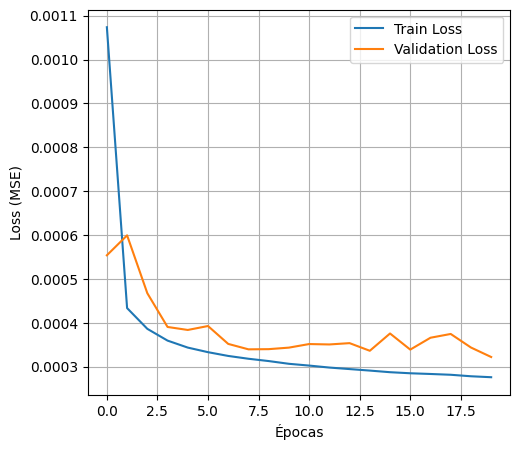

In [15]:
# Treinamento do modelo LSTM para o torque
torque_model = LSTM_model(torque_X_train_seq, torque_y_train_seq, train_size=0.8, epochs=20, batch_size=128)
torque_model.summary()

6824/6824 ━━━━━━━━━━━━━━━━━━━━ 4s 536us/step


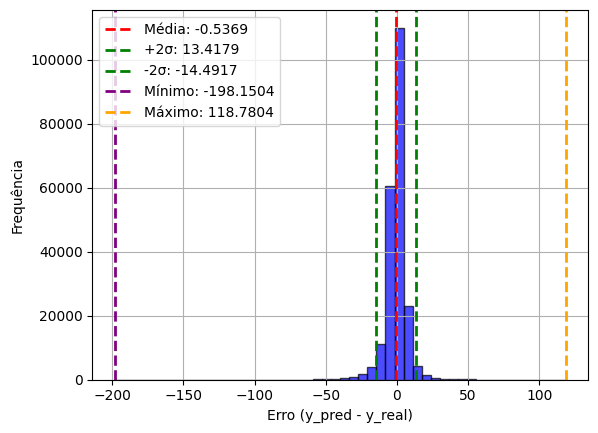

In [16]:
# Realizando as predições do torque para a base de testes
torque_y_pred_seq = torque_model.predict(torque_X_test_seq)

# Exibindo o erro desnormalizado entre o predito e o real
plot_error_histogram(
    torque_y_scaler.inverse_transform(torque_y_pred_seq), 
    torque_y_scaler.inverse_transform(torque_y_test_seq.reshape(len(torque_y_test_seq), 1)),
    bins=50
)

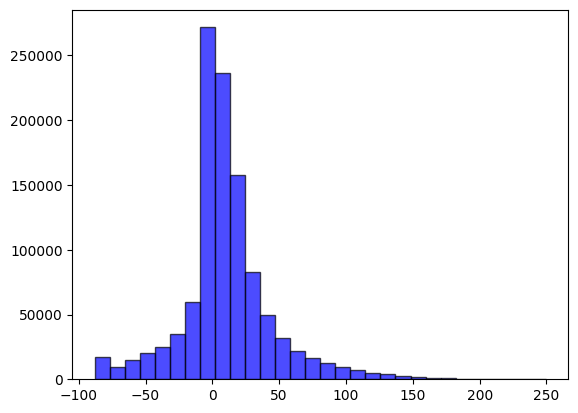

In [17]:
# Histograma com os valores do torque desnormalizado para comparar a dimensão do erro no gráfico anterior
plt.hist(trips['Motor Torque [Nm]'], bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.show()

### Throttle

In [18]:
# Visualizando o dataset original limpo, com colunas selecionadas, ordenado e concatenado. 
# Pronto para o trabalho.
# Foi lido no início dessa terceira análise.
trips.head()

,Ambient Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Longitudinal Acceleration [m/s^2],Throttle [%],Velocity [km/h],Motor Torque [Nm],Time [s],Trip
0,25.5,24.5,30.5,-0.03,0.0,0.0,0.0,0.0,TripA01
1,25.5,24.5,30.5,0.00,0.0,0.0,0.0,0.1,TripA01
2,25.5,24.5,30.5,-0.01,0.0,0.0,0.0,0.2,TripA01
3,25.5,24.5,30.5,-0.03,0.0,0.0,0.0,0.3,TripA01
4,25.5,24.5,30.5,-0.03,0.0,0.0,0.0,0.4,TripA01


In [21]:
# Normalizando o dataset com a coluna throttle como rótulo
throttle_scaled_dataset, throttle_X_scaler, throttle_y_scaler = normalize(trips, 'Throttle [%]')
throttle_scaled_dataset.head()

,Ambient Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Longitudinal Acceleration [m/s^2],Velocity [km/h],Time [s],Trip,Throttle [%]
0,0.783784,0.485904,0.424646,0.667161,0.0,0.000000,TripA01,0.0
1,0.783784,0.485904,0.424646,0.669385,0.0,0.000018,TripA01,0.0
2,0.783784,0.485904,0.424646,0.668643,0.0,0.000036,TripA01,0.0
3,0.783784,0.485904,0.424646,0.667161,0.0,0.000053,TripA01,0.0
4,0.783784,0.485904,0.424646,0.667161,0.0,0.000071,TripA01,0.0


In [22]:
# Realizando a divisão de treino e teste para o throttle.
# A impressão mostra o head de cada um dos datasets produzidos com os seus respectivos shapes para comparar as proporções.
# Por padrão é 80-20, mas pode trocar no parâmetro da função
throttle_X_train, throttle_X_test, throttle_y_train, throttle_y_test = time_series_train_test_split(throttle_scaled_dataset, 'Throttle [%]', 'Trip')
print(f"\nthrottle_X_train: {throttle_X_train.shape}")
display(throttle_X_train.head())

print(f"\nthrottle_X_test: {throttle_X_test.shape}")
display(throttle_X_test.head())

print(f"\nthrottle_y_train: {throttle_y_train.shape}")
display(throttle_y_train.head())

print(f"\nthrottle_y_test: {throttle_y_test.shape}")
display(throttle_y_test.head())


throttle_X_train: (875810, 7)


,Ambient Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Longitudinal Acceleration [m/s^2],Velocity [km/h],Time [s],Trip
0,0.783784,0.485904,0.424646,0.667161,0.0,0.000000,TripA01
1,0.783784,0.485904,0.424646,0.669385,0.0,0.000018,TripA01
2,0.783784,0.485904,0.424646,0.668643,0.0,0.000036,TripA01
3,0.783784,0.485904,0.424646,0.667161,0.0,0.000053,TripA01
4,0.783784,0.485904,0.424646,0.667161,0.0,0.000071,TripA01



throttle_X_test: (218983, 7)


,Ambient Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Longitudinal Acceleration [m/s^2],Velocity [km/h],Time [s],Trip
8072,0.959459,0.413521,0.0,0.676798,0.001773,0.143883,TripA01
8073,0.959459,0.413521,0.0,0.633803,0.001314,0.143901,TripA01
8074,0.959459,0.413521,0.0,0.624166,0.001117,0.143919,TripA01
8075,0.959459,0.413521,0.0,0.643440,0.000854,0.143937,TripA01
8076,0.959459,0.413521,0.0,0.642698,0.000722,0.143955,TripA01



throttle_y_train: (875810,)


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Throttle [%], dtype: float64


throttle_y_test: (218983,)


8072    0.0
8073    0.0
8074    0.0
8075    0.0
8076    0.0
Name: Throttle [%], dtype: float64

In [23]:
# Criando os cubos de dados para X e y de treino e teste. 
# Isso é necessário para os dados estarem no formato adequado do LSTM.
# Aqui eu defino o tamanho da janela do LSTM.
throttle_X_train_seq, throttle_y_train_seq = create_seq(throttle_X_train, throttle_y_train.values, 'Trip', window_size=WINDOW_SIZE)
throttle_X_test_seq, throttle_y_test_seq = create_seq(throttle_X_test, throttle_y_test.values, 'Trip', window_size=WINDOW_SIZE)

print("TRAIN:")
print(f"throttle_X_train_seq {throttle_X_train_seq.shape}")
print(f"throttle_y_train_seq {throttle_y_train_seq.shape}")
print("\nTEST:")
print(f"throttle_X_test_seq {throttle_X_test_seq.shape}")
print(f"throttle_y_test_seq {throttle_y_test_seq.shape}")

TRAIN:
throttle_X_train_seq (875179, 10, 6)
throttle_y_train_seq (875179,)

TEST:
throttle_X_test_seq (218352, 10, 6)
throttle_y_test_seq (218352,)


Epoch 1/20
5470/5470 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0062 - mae: 0.0552 - val_loss: 0.0038 - val_mae: 0.0412
Epoch 2/20
5470/5470 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0139 - val_mae: 0.0641
Epoch 3/20
5470/5470 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0026 - mae: 0.0331 - val_loss: 0.0073 - val_mae: 0.0530
Epoch 4/20
5470/5470 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0023 - mae: 0.0312 - val_loss: 0.0053 - val_mae: 0.0474
Epoch 5/20
5470/5470 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0021 - mae: 0.0296 - val_loss: 0.0059 - val_mae: 0.0470
Epoch 6/20
5470/5470 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0020 - mae: 0.0283 - val_loss: 0.0054 - val_mae: 0.0433
Epoch 7/20
5470/5470 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0019 - mae: 0.0273 - val_loss: 0.0055 - val_mae: 0.0424
Epoch 8/20
5470/5470 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0018 - mae: 0.0268 - val_loss: 0.0060 - val_mae: 0.0445
Epoch 9/20
5470/5470 ━━━━━━━━━━━

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,245 (71.27 KB)

 Trainable params: 6,081 (23.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,164 (47.52 KB)

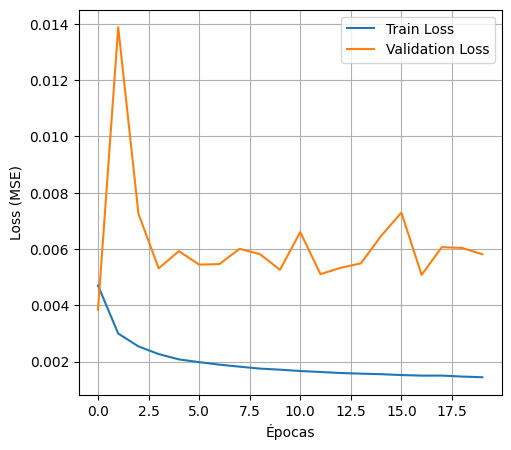

In [24]:
# Treinamento do modelo LSTM para o throttle
throttle_model = LSTM_model(throttle_X_train_seq, throttle_y_train_seq, train_size=0.8, epochs=20, batch_size=128)
throttle_model.summary()

6824/6824 ━━━━━━━━━━━━━━━━━━━━ 3s 478us/step


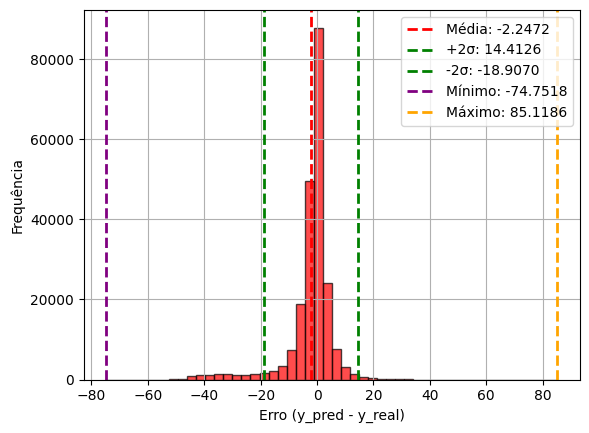

In [25]:
# Realizando as predições do torque para a base de testes
throttle_y_pred_seq = throttle_model.predict(throttle_X_test_seq)

# Exibindo o erro desnormalizado entre o predito e o real
plot_error_histogram(
    throttle_y_scaler.inverse_transform(throttle_y_pred_seq), 
    throttle_y_scaler.inverse_transform(throttle_y_test_seq.reshape(len(throttle_y_test_seq), 1)),
    bins=50,
    color='red'
)

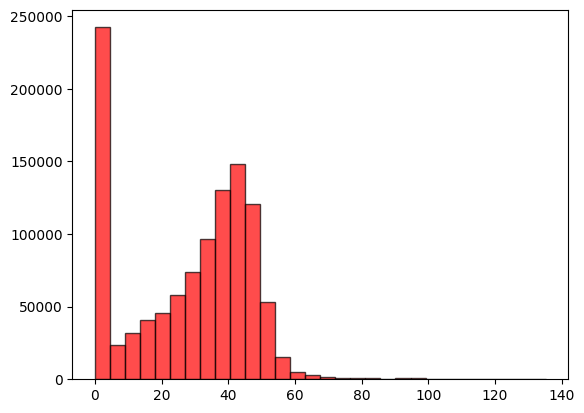

In [26]:
# Histograma com os valores do torque desnormalizado para comparar a dimensão do erro no gráfico anterior
plt.hist(trips['Throttle [%]'], bins=30, color='red', alpha=0.7, edgecolor='black')
plt.show()

### Timeline

In [29]:
# Esse é o X de teste da minha timeline que eu vou predizer em cima dele normalizado
# Já está filtrado somente pela jornada TripA01
timeline_X = torque_X_test[torque_X_test['Trip'] == 'TripA01']

# Esse é o y de teste da minha timeline desnormalizado
# Está filtrado pela jornada TripA01
# Eu filtrei nos dados originais e peguei os 20% finais para ser a parte de teste.
# Como é uma série temporal, eu garanto que serão os rótulos correspondentes ao X da linha anterior
total_trip_size = len(trips[trips['Trip'] == 'TripA01'])
train_size = int(total_trip_size*0.8)
timeline_y = trips[trips['Trip'] == 'TripA01'][train_size:]['Motor Torque [Nm]']

# Criando o janelamento do X e do y para rodar no LSTM
timeline_X_seq, timeline_y_seq = create_seq(timeline_X, timeline_y.values, 'Trip', window_size=WINDOW_SIZE)

# Realizando a predição com o modelo treinado e desnormalizando
timeline_y_pred_seq = torque_model.predict(timeline_X_seq)
timeline_y_pred_seq_desnorm = torque_y_scaler.inverse_transform(timeline_y_pred_seq)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step


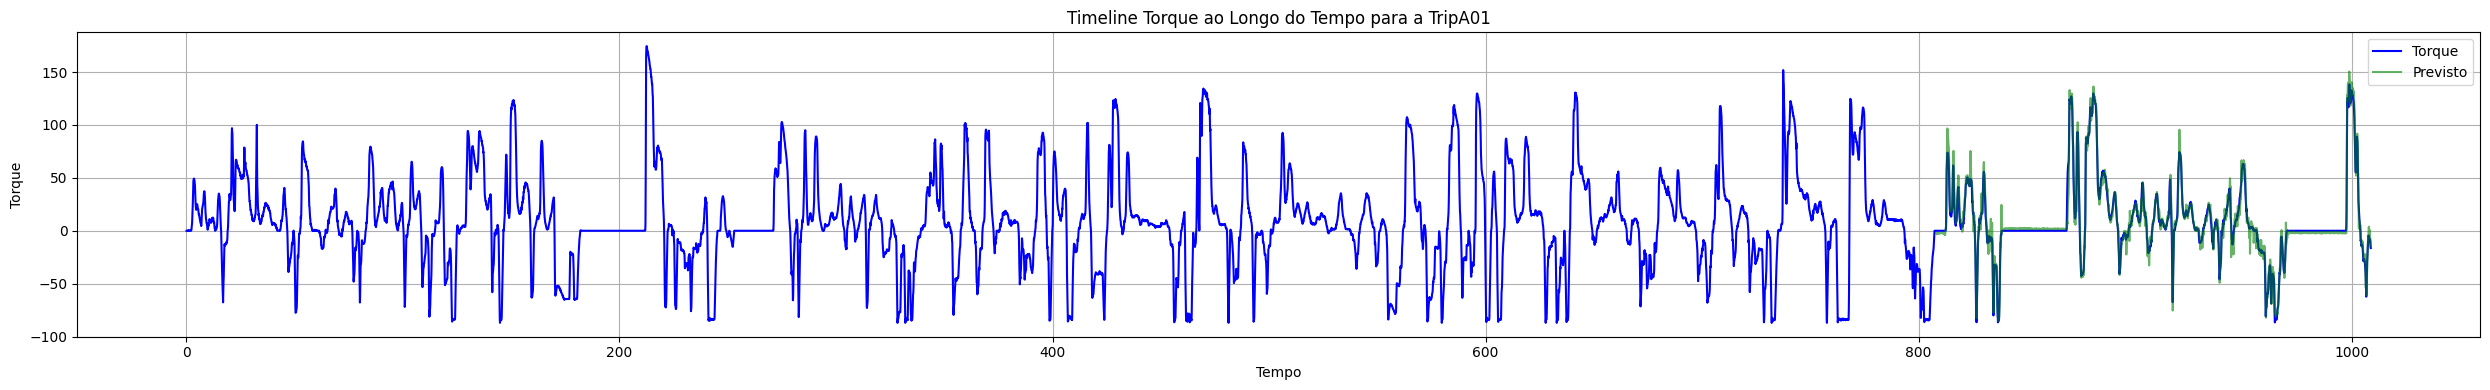

In [30]:
# Plotando a linha do tempo original da jornada TripA01 em azul
plt.figure(figsize=(25, 4))
plt.plot(
    trips[trips['Trip'] == 'TripA01']['Time [s]'], 
    trips[trips['Trip'] == 'TripA01']['Motor Torque [Nm]'], 
    label='Torque',
    color='blue'
)

# Plotando a linha predita pelo modelo em verde transparente no final da timeline anterior
plt.plot(
    # Para conseguir o tempo, eu preciso pegar o X usado em teste e desnormalizar.
    # Como a normalização do X foi feita com as 6 colunas, eu preciso usar as mesmas colunas e remover a coluna Trip
    # A janela tem um tamanho pré-defindo, por exemplo 10. Nesse caso, ele usa 10 valores para predizer o décimo primeiro e assim continua até o final do dataset.
    # Logo, os 10 primeiros valores não terãouma predição, então eu pego de WINDOW_SIZE até o final.
    # Eu tinha 5 colunas no X e só preciso do tempo aqui, então, eu pelo a coluna 5 que corresponde a sexta no intervalo de 0 a 5.
    torque_X_scaler.inverse_transform(timeline_X.drop(columns=['Trip'], axis=1)[WINDOW_SIZE:].values)[:, 5],
    timeline_y_pred_seq_desnorm,
    label='Previsto',
    color='green',
    alpha=0.6
)

# Configurações do gráfico
plt.xlabel('Tempo')
plt.ylabel('Torque')
plt.title('Timeline Torque ao Longo do Tempo para a TripA01')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [31]:
# Mesma linha de raciocínio do torque só que para o throttle - preparando os dados
throttle_timeline_X = throttle_X_test[throttle_X_test['Trip'] == 'TripA01']

total_trip_size = len(trips[trips['Trip'] == 'TripA01'])
train_size = int(total_trip_size*0.8)
throttle_timeline_y = trips[trips['Trip'] == 'TripA01'][train_size:]['Throttle [%]']

throttle_timeline_X_seq, throttle_timeline_y_seq = create_seq(throttle_timeline_X, throttle_timeline_y.values, 'Trip', window_size=WINDOW_SIZE)

throttle_timeline_y_pred_seq = throttle_model.predict(throttle_timeline_X_seq)
throttle_timeline_y_pred_seq_desnorm = throttle_y_scaler.inverse_transform(throttle_timeline_y_pred_seq)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step


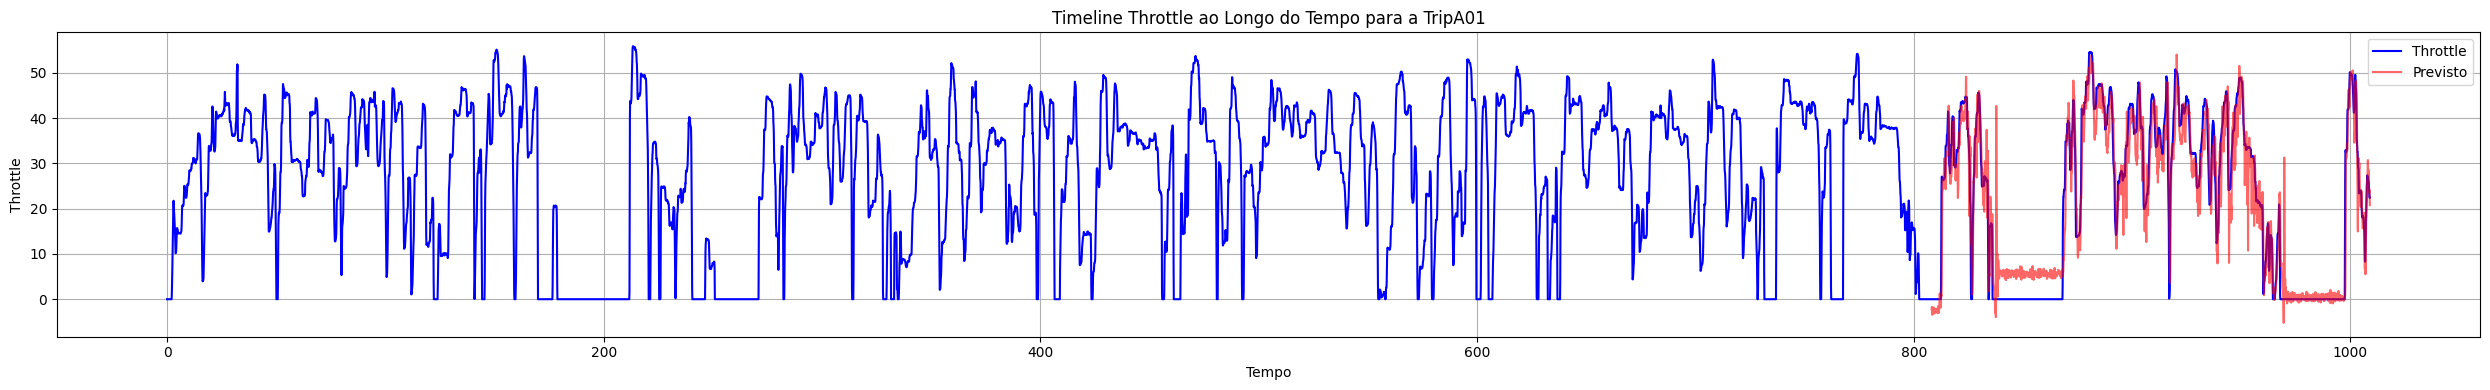

In [32]:
# Mesma linha de raciocínio do torque só que para o throttle - exibindo a timeline
plt.figure(figsize=(25, 4))
plt.plot(
    trips[trips['Trip'] == 'TripA01']['Time [s]'], 
    trips[trips['Trip'] == 'TripA01']['Throttle [%]'], 
    label='Throttle',
    color='blue'
)

plt.plot(
    throttle_X_scaler.inverse_transform(throttle_timeline_X.drop(columns=['Trip'], axis=1)[WINDOW_SIZE:].values)[:, 5],
    throttle_timeline_y_pred_seq_desnorm,
    label='Previsto',
    color='red',
    alpha=0.6
)

plt.xlabel('Tempo')
plt.ylabel('Throttle')
plt.title('Timeline Throttle ao Longo do Tempo para a TripA01')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

## Otimização de Hiperparâmetros com Optuna

### Definitions

In [1]:
# Esse export é para retirar um warning do tensorflow, não precisa se importar com isso aqui.
!export TF_ENABLE_ONEDNN_OPTS=0

In [48]:
# Importações
import optuna

import os
import pandas as pd
import numpy as np

from functools import partial
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from IPython.display import display


# Parâmetros gerais comuns a todos os estudos
WINDOW_SIZE = 10
TRAIN_SIZE = 0.8
EPOCHS = 4
TRIALS = 5

In [6]:
def read_database(directory):
    """
    Lê as bases de dados e prepara para utilizar.

    Args:
        drectory (str): Caminho da pasta que contem os arquivos .csv que compõem o dataset das trips.

    Returns:
        pandas.DataFrame: Dataset com as viagens lidas e preparadas para usar.
    """
    # Leitura do diretório e ordenação alfabética dos arquivos.
    files = os.listdir(directory)
    files.sort()

    # Leitura dos datasets, ordenação pelo tempo, adição da coluna identificadora da origem do registro,
    # correção da grafia da velocidade e adição na lista de trips.
    trips = []
    for file in files:
        trip = pd.read_csv(directory + file, sep=";", encoding='unicode_escape')
        trip = trip.sort_values(by='Time [s]')
        trip['Trip'] = file.split(".")[0]
        if 'Velocity [km/h]]]' in trip.columns:
            trip = trip.rename(columns={'Velocity [km/h]]]': 'Velocity [km/h]'})
        trips.append(trip)
    
    # Estou utilizando somente as colunas do dataset que possuem uma equivalente no dataset de combustão que o Daniel me enviou.
    # A seguir tem um mapa das variáveis no elétrico para as variáveis no dataset de combustão. Isso será importante para a segunda 
    # etapa do projeto de emissões de CO2.
    
    # Mapa:
    # 'Ambient Temperature [°C]': 'Veh_ambient_temp_ECM',
    # 'Cabin Temperature Sensor [°C]': 'HVAC_pass_compartment_air_temp_filt_HVAC',
    # 'Heat Exchanger Temperature [°C]': 'HVAC_heater_core_coolant_temp_sensor_HVAC',
    # 'Longitudinal Acceleration [m/s^2]': 'ActVehAccel',
    # 'Throttle [%]': 'Eng_throttle_pos_ECM',
    # 'Velocity [km/h]': 'VehSpdAvgDrvn'
    
    # Colunas selecionadas do elétrico por ter equivalente no combustão.
    colunas_selecionadas = [
        'Ambient Temperature [°C]',
        'Cabin Temperature Sensor [°C]',
        'Heat Exchanger Temperature [°C]',
        'Longitudinal Acceleration [m/s^2]',
        'Throttle [%]',
        'Velocity [km/h]',
        'Motor Torque [Nm]',
        'Time [s]',
        'Trip'
    ]
    
    # Concatenação de todos os datasets e seleção das colunas
    trips = pd.concat(trips)
    trips = trips[colunas_selecionadas]
    return trips

In [7]:
def normalize(data, label):
    """
    Realiza a normalização dos dados.

    Args:
        data (pandas.DataFrame): Dataset com os dados que serão normalizados.
        label (string): Nome da coluna que será o rótulo.

    Returns:
        scaled_dataset (pandas.DataFrame): Dataset incial normalizado.
        scaler_X (sklearn.preprocessing.MinMaxScaler): Normalizador e desnormalizador do X.
        scaler_y (sklearn.preprocessing.MinMaxScaler): Normalizador e desnormalizador do y.
    """
    # Colunas que serão utilizadas no X.
    # Estou deixando 'Time [s]' no X pq os intervalos de tempo não são regulares
    columns = ['Trip', 'Throttle [%]', 'Motor Torque [Nm]']

    # Separação do X e do y para normalizar
    X = data.drop(columns=columns)
    y = data[label].values

    # Criação dos scalers
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Normalização
    X_scaled = scaler_X.fit_transform(X.values)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    # Remontagem do pandas.DataFrame original só que normalizado.
    # Eu retorno o nome das colunas, os índices, a coluna que identifica a viagem que gerou o registro e o y.
    X_scaled = pd.DataFrame(
        X_scaled,
        columns=X.columns,
        index=X.index
    )
    X_scaled['Trip'] = data['Trip']
    scaled_dataset = X_scaled
    scaled_dataset[label] = y_scaled

    return scaled_dataset, scaler_X, scaler_y

In [8]:
def time_series_train_test_split(dataset, label, train_size=TRAIN_SIZE):
    """
    Realiza a divisão de treino e teste de N séries temporais.

    Args:
        dataset (pandas.DataFrame): Dataset com os dados que serão divididos.
        label (string): Nome da coluna que será o rótulo y.
        id_column (string): Nome da coluna que tem o identificador das trips.
        train_size (float): Tamanho da fatia de dados para o treinamento.

    Returns:
        X_train (pandas.DataFrame): Dataframe com os X das N séries para treino.
        X_test (pandas.DataFrame): Dataframe com os X das N séries para test.
        y_train (pandas.DataFrame): Dataframe com os y das N séries para treino.
        y_test (pandas.DataFrame): Dataframe com os y das N séries para test.
    """
    # Listas para guardar os slices de DataFrames referentes aos retornos no final
    X_trains, X_tests, y_trains, y_tests = [], [], [], []    

    # Passa por todas as trips diferentes que tem na coluna identificadora.
    for trip in dataset['Trip'].unique():
        # Pega uma trip e calcula o número de registros que ficarão para treino
        data_slice = dataset[dataset['Trip'] == trip]
        size = int(len(data_slice) * train_size)

        # Realiza o slices do X treino e teste
        X_trains.append(data_slice.drop(columns=[label]).iloc[:size, :])
        X_tests.append(data_slice.drop(columns=[label]).iloc[size:, :])

        # Realiza os slices do y treino e teste
        y_trains.append(data_slice[label].iloc[:size])
        y_tests.append(data_slice[label].iloc[size:])
        
     # Concatena os conteúdos de cada uma das listas e retorna os pandas.DataFrames
    return pd.concat(X_trains), pd.concat(X_tests), pd.concat(y_trains), pd.concat(y_tests)

In [9]:
def create_seq(X, y, window_size=WINDOW_SIZE):
    """
    O LSTM precisa de um cubo de dados adicionando a dimensão tamanho da janela.
    Ou seja, inicialmente eu tenho linhas (registros) e colunas (features), eu preciso fazer uma 
    lista de conjuntos de registros do tamanho do window_size. Nesse caso, terei uma dimensão para
    escolher qual o conjunto na lista, uma dimensão para saber qual a linha no conjunto e uma dimensão
    para saber qual a coluna. Esse será o cubo de dados em numpy.array.

    Args:
        X (pandas.DataFrame): Dataset contendo o X de N séries temporais, com uma coluna identificadora.
        y (pandas.Series): Série contendo o y de N séries temporais.
        id_column (string): Nome da coluna que guarda a identificação de cada uma das séries temporais.
        window_size (int): Tamanho da janela que será usada no LSTM.

    Returns:
        X_seq (numpy.array): Cubo de dados dos X obtidos.
        y_seq (numpy.array): Array com os y relativos ao X_seq.
    """
    # Listas para guardar os resultados de cada uma das séries temporais
    X_seq, y_seq = [], []

    # Loop que inicia no tamanho da janela e vai até o tamanho de X
    for i in range(window_size, len(X)):
        # Recorte da janela. Obserque vai de i - janela até i, ou seja, do tamanho da janela.
        # Pega todas as colunas.
        data_slice = X.iloc[i-window_size:i, :]

        # Se tiver mais de uma trip na mesma janela, eu não adiciono no conjunto de dados
        # Não faz sentido janelas que começam no final de uma trip e tem dados do início de outra.
        if len(data_slice['Trip'].unique()) == 1:
            X_seq.append(data_slice.drop(columns=['Trip']).values)    # Adiciono o slice que eu fiz, dropando a coluna identificadora e passando para numpy.array
            y_seq.append(y[i])    # Pego o y referente ao último registro da janela.
        
    return np.array(X_seq), np.array(y_seq)    # Retorno os numpy.arrays que são a concatenação de todas as trips.

### Database Preparation

In [10]:
# Lendo os arquivos das viagens e montando o dataframe original
trips = read_database("./data/ieee/")
trips.shape

(1094793, 9)

In [11]:
# Normalizando o dataframe para o torque
torque_scaled_dataset, torque_X_scaler, torque_y_scaler = normalize(trips, 'Motor Torque [Nm]')
display(torque_scaled_dataset.head())

# Normalizando o dataframe para o throttle
throttle_scaled_dataset, throttle_X_scaler, throttle_y_scaler = normalize(trips, 'Throttle [%]')
display(throttle_scaled_dataset.head())

,Ambient Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Longitudinal Acceleration [m/s^2],Velocity [km/h],Time [s],Trip,Motor Torque [Nm]
0,0.783784,0.485904,0.424646,0.667161,0.0,0.000000,TripA01,0.260522
1,0.783784,0.485904,0.424646,0.669385,0.0,0.000018,TripA01,0.260522
2,0.783784,0.485904,0.424646,0.668643,0.0,0.000036,TripA01,0.260522
3,0.783784,0.485904,0.424646,0.667161,0.0,0.000053,TripA01,0.260522
4,0.783784,0.485904,0.424646,0.667161,0.0,0.000071,TripA01,0.260522


,Ambient Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Longitudinal Acceleration [m/s^2],Velocity [km/h],Time [s],Trip,Throttle [%]
0,0.783784,0.485904,0.424646,0.667161,0.0,0.000000,TripA01,0.0
1,0.783784,0.485904,0.424646,0.669385,0.0,0.000018,TripA01,0.0
2,0.783784,0.485904,0.424646,0.668643,0.0,0.000036,TripA01,0.0
3,0.783784,0.485904,0.424646,0.667161,0.0,0.000053,TripA01,0.0
4,0.783784,0.485904,0.424646,0.667161,0.0,0.000071,TripA01,0.0


In [12]:
# Realizando a divisão de treino e teste para o torque
torque_X_train, torque_X_test, torque_y_train, torque_y_test = time_series_train_test_split(torque_scaled_dataset, 'Motor Torque [Nm]')
print(f"\ntorque_X_train: {torque_X_train.shape}")
display(torque_X_train.head())

print(f"\ntorque_X_test: {torque_X_test.shape}")
display(torque_X_test.head())

print(f"\ntorque_y_train: {torque_y_train.shape}")
display(torque_y_train.head())

print(f"\ntorque_y_test: {torque_y_test.shape}")
display(torque_y_test.head())


torque_X_train: (875810, 7)


,Ambient Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Longitudinal Acceleration [m/s^2],Velocity [km/h],Time [s],Trip
0,0.783784,0.485904,0.424646,0.667161,0.0,0.000000,TripA01
1,0.783784,0.485904,0.424646,0.669385,0.0,0.000018,TripA01
2,0.783784,0.485904,0.424646,0.668643,0.0,0.000036,TripA01
3,0.783784,0.485904,0.424646,0.667161,0.0,0.000053,TripA01
4,0.783784,0.485904,0.424646,0.667161,0.0,0.000071,TripA01



torque_X_test: (218983, 7)


,Ambient Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Longitudinal Acceleration [m/s^2],Velocity [km/h],Time [s],Trip
8072,0.959459,0.413521,0.0,0.676798,0.001773,0.143883,TripA01
8073,0.959459,0.413521,0.0,0.633803,0.001314,0.143901,TripA01
8074,0.959459,0.413521,0.0,0.624166,0.001117,0.143919,TripA01
8075,0.959459,0.413521,0.0,0.643440,0.000854,0.143937,TripA01
8076,0.959459,0.413521,0.0,0.642698,0.000722,0.143955,TripA01



torque_y_train: (875810,)


0    0.260522
1    0.260522
2    0.260522
3    0.260522
4    0.260522
Name: Motor Torque [Nm], dtype: float64


torque_y_test: (218983,)


8072    0.236811
8073    0.246829
8074    0.260522
8075    0.260522
8076    0.260522
Name: Motor Torque [Nm], dtype: float64

In [13]:
# Realizando a divisão de treino e teste para o throttle
throttle_X_train, throttle_X_test, throttle_y_train, throttle_y_test = time_series_train_test_split(throttle_scaled_dataset, 'Throttle [%]')
print(f"\nthrottle_X_train: {throttle_X_train.shape}")
display(throttle_X_train.head())

print(f"\nthrottle_X_test: {throttle_X_test.shape}")
display(throttle_X_test.head())

print(f"\nthrottle_y_train: {throttle_y_train.shape}")
display(throttle_y_train.head())

print(f"\nthrottle_y_test: {throttle_y_test.shape}")
display(throttle_y_test.head())


throttle_X_train: (875810, 7)


,Ambient Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Longitudinal Acceleration [m/s^2],Velocity [km/h],Time [s],Trip
0,0.783784,0.485904,0.424646,0.667161,0.0,0.000000,TripA01
1,0.783784,0.485904,0.424646,0.669385,0.0,0.000018,TripA01
2,0.783784,0.485904,0.424646,0.668643,0.0,0.000036,TripA01
3,0.783784,0.485904,0.424646,0.667161,0.0,0.000053,TripA01
4,0.783784,0.485904,0.424646,0.667161,0.0,0.000071,TripA01



throttle_X_test: (218983, 7)


,Ambient Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Longitudinal Acceleration [m/s^2],Velocity [km/h],Time [s],Trip
8072,0.959459,0.413521,0.0,0.676798,0.001773,0.143883,TripA01
8073,0.959459,0.413521,0.0,0.633803,0.001314,0.143901,TripA01
8074,0.959459,0.413521,0.0,0.624166,0.001117,0.143919,TripA01
8075,0.959459,0.413521,0.0,0.643440,0.000854,0.143937,TripA01
8076,0.959459,0.413521,0.0,0.642698,0.000722,0.143955,TripA01



throttle_y_train: (875810,)


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Throttle [%], dtype: float64


throttle_y_test: (218983,)


8072    0.0
8073    0.0
8074    0.0
8075    0.0
8076    0.0
Name: Throttle [%], dtype: float64

In [14]:
# Criando o cubo de dados para o torque
torque_X_train_seq, torque_y_train_seq = create_seq(torque_X_train, torque_y_train.values, window_size=WINDOW_SIZE)
torque_X_test_seq, torque_y_test_seq = create_seq(torque_X_test, torque_y_test.values, window_size=WINDOW_SIZE)

print("TRAIN:")
print(f"torque_X_train_seq {torque_X_train_seq.shape}")
print(f"torque_y_train_seq {torque_y_train_seq.shape}")
print("\nTEST:")
print(f"torque_X_test_seq {torque_X_test_seq.shape}")
print(f"torque_y_test_seq {torque_y_test_seq.shape}")

TRAIN:
torque_X_train_seq (875179, 10, 6)
torque_y_train_seq (875179,)

TEST:
torque_X_test_seq (218352, 10, 6)
torque_y_test_seq (218352,)


In [15]:
# Criando o cubo de dados para o throttle
throttle_X_train_seq, throttle_y_train_seq = create_seq(throttle_X_train, throttle_y_train.values, window_size=WINDOW_SIZE)
throttle_X_test_seq, throttle_y_test_seq = create_seq(throttle_X_test, throttle_y_test.values, window_size=WINDOW_SIZE)

print("TRAIN:")
print(f"throttle_X_train_seq {throttle_X_train_seq.shape}")
print(f"throttle_y_train_seq {throttle_y_train_seq.shape}")
print("\nTEST:")
print(f"throttle_X_test_seq {throttle_X_test_seq.shape}")
print(f"throttle_y_test_seq {throttle_y_test_seq.shape}")

TRAIN:
throttle_X_train_seq (875179, 10, 6)
throttle_y_train_seq (875179,)

TEST:
throttle_X_test_seq (218352, 10, 6)
throttle_y_test_seq (218352,)


### Optuna Definitions

In [46]:
# Eu redefini as funções próprias para serem utilizadas no optuna.
# Desse modo, a alteração aqui não afetaria o restante do notebook.
# Essas funções serão utilizadas nos estudos do optuna.

def optuna_results(study):
    """
    Imprime os resultados de um estudo do optuna.

    Args:
        study (optuna.study.Study): Estudo realizado no optuna para impressão dos resultados
    """
    # Selecionando o melhor trial para impressão
    best = study.best_trial

    # Imprimindo o melhor erro e os hiperparâmetros utilizados
    print("Melhor valor objetivo:", best.value)
    print("Hiperparâmetros:")
    for key, value in best.params.items():
        print(f"  {key}: {value}")

In [67]:
# Essa é a função objetivo que é minimizada pelo optuna
def objective(trial, func, X_train, y_train, X_test, y_test):
    """
    Essa é a função objetivo que terá o seu retorno minimizado para poder achar o melhor trial do estudo

    Args:
        trial (optuna.trial.Trial): Tentativa do estudo que está sendo realizada pelo optuna no momento.
        func (function): É a função que será utilizada para montar a arquitetura da rede LSTM que será estudada.
        X_train (numpy.array): Cubo de dados contendo o X de treino.
        y_train (numpy.array): Cubo de dados contendo o y de treino.
        X_test (numpy.array): Cubo de dados contendo o X de validação.
        y_test (numpy.array): Cubo de dados contendo o y de validação.

    Returns:
        float: Valor do val_loss que será minimizado pelo optuna.
    """
    # O tamanho do batch_size também é um parâmetro para o optuna.
    batch_size_units = trial.suggest_int("batch_size", 32, 128, step=32)

    # Aqui eu defino o input shape para passar para construir a camada de entrada da rede neural.
    # Observe que eu tive que pegar de uma variável global pq o optuna não deixa passar parâmetros para a função objetivo.
    # Nesse caso, antes de rodar o estudo, eu defino essas duas variáveis
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Criação do modelo para esse estudo
    model = func(trial, input_shape)

    # Treinamento efetivo do modelo passando as mesmas variáveis globais que eu indiquei antes
    history = model.fit(
        X_train, y_train, 
        validation_data=(X_test, y_test), 
        epochs=EPOCHS, 
        batch_size=batch_size_units
    )

    # Pegando o último val_loss para poder retornar
    val_loss = history.history["val_loss"][-1]
    return val_loss

In [68]:
def study_01_LSTM_model(trial, input_shape):
    """
    Cria uma arquitetura de uma rede neural para um estudo do optuna.

    Args:
        trial (optuna.trial.Trial): Tentativa do estudo que está sendo realizada pelo optuna no momento.
        input_shape (tuple[int, int]): Tupla com o formato da camada de entrada do LSTM

    Returns:
        tf.keras.Sequential: Modelo construido para ser treinado.
    """
    # Criando uma rede neural do tipo sequencial do tensorflow
    model = Sequential()

    # Parâmetros e intervalos utilizados para definir o campo de busca do optuna.
    # Cada um deles será sorteado a cada trial para compor os estudos
    # A variação dos parâmetros é no formato nome, inicial, final e step
    lstm_units = trial.suggest_int("lstm_units", 16, 64, step=16)
    dense_units = trial.suggest_int("dense_units", 16, 64, step=16)
    lstm_activation_units = trial.suggest_categorical("lstm_activation", ["relu", "tanh", "sigmoid", "linear"])
    dense_activation_units = trial.suggest_categorical("dense_activation", ["relu", "tanh", "sigmoid", "linear"])
    learning_rate_units = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)    # Nesse caso os steps são logarítmicos

    # Arquitetura da rede neural definida para o estudo
    # Input -> LSTM -> Dense -> Dense(saída)
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=lstm_units, activation=lstm_activation_units))
    model.add(Dense(units=dense_units, activation=dense_activation_units))
    model.add(Dense(1))

    # Definição do Adam como otimizador e usando o learning_rate como parâmetro do optuna também
    optimizer = Adam(learning_rate=learning_rate_units)

    # Compilando o modelo para poder treinar depois na função objetivo
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [69]:
# Os comentários são semelhantes ao do estudo 01.
# Estou comentando somente as diferenças

def study_02_LSTM_model(trial, input_shape):
    """
    Cria uma arquitetura de uma rede neural para um estudo do optuna.

    Args:
        trial (optuna.trial.Trial): Tentativa do estudo que está sendo realizada pelo optuna no momento.
        input_shape (tuple[int, int]): Tupla com o formato da camada de entrada do LSTM

    Returns:
        tf.keras.Sequential: Modelo construido para ser treinado.
    """
    model = Sequential()

    # Parâmetros e intervalos utilizados para definir o campo de busca do optuna.
    # Cada um deles será sorteado a cada trial para compor os estudos
    # A variação dos parâmetros é no formato nome, inicial, final e step
    lstm_units = trial.suggest_int("lstm_units", 16, 64, step=16)
    dense_units = trial.suggest_int("dense_units", 16, 64, step=16)
    lstm_activation_units = trial.suggest_categorical("lstm_activation", ["relu", "tanh", "sigmoid", "linear"])
    dense_activation_units = trial.suggest_categorical("dense_activation", ["relu", "tanh", "sigmoid", "linear"])
    learning_rate_units = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    recurrent_dropout = trial.suggest_float("recurrent_dropout", 0.0, 0.5)

    # Arquitetura da rede neural definida para o estudo
    # Input -> LSTM -> Dropout -> Dense -> Dense(saída)
    model.add(Input(shape=(optuna_X_train.shape[1], optuna_X_train.shape[2])))
    model.add(LSTM(units=lstm_units, activation=lstm_activation_units, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dense(units=dense_units, activation=dense_activation_units))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate_units)
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [70]:
# Os comentários são semelhantes ao do estudo 01.
# Estou comentando somente as diferenças

def study_03_LSTM_model(trial, input_shape):
    """
    Cria uma arquitetura de uma rede neural para um estudo do optuna.

    Args:
        trial (optuna.trial.Trial): Tentativa do estudo que está sendo realizada pelo optuna no momento.
        input_shape (tuple[int, int]): Tupla com o formato da camada de entrada do LSTM

    Returns:
        tf.keras.Sequential: Modelo construido para ser treinado.
    """
    model = Sequential()

    # Parâmetros e intervalos utilizados para definir o campo de busca do optuna.
    # Cada um deles será sorteado a cada trial para compor os estudos
    # A variação dos parâmetros é no formato nome, inicial, final e step
    lstm1_units = trial.suggest_int("lstm1_units", 16, 64, step=16)
    lstm2_units = trial.suggest_int("lstm2_units", 16, 64, step=16)
    dense_units = trial.suggest_int("dense_units", 16, 64, step=16)
    lstm1_activation_units = trial.suggest_categorical("lstm_activation_1", ["relu", "tanh", "sigmoid", "linear"])
    lstm2_activation_units = trial.suggest_categorical("lstm_activation_2", ["relu", "tanh", "sigmoid", "linear"])
    dense_activation_units = trial.suggest_categorical("dense_activation", ["relu", "tanh", "sigmoid", "linear"])
    learning_rate_units = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)

    # Arquitetura da rede neural definida para o estudo
    # Input -> LSTM -> LSTM -> Dense -> Dense(saída)
    model.add(Input(shape=(optuna_X_train.shape[1], optuna_X_train.shape[2])))
    model.add(LSTM(units=lstm1_units, return_sequences=True, activation=lstm1_activation_units))
    model.add(LSTM(units=lstm2_units, activation=lstm2_activation_units))
    model.add(Dense(units=dense_units, activation=dense_activation_units))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate_units)
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [71]:
# Os comentários são semelhantes ao do estudo 01.
# Estou comentando somente as diferenças

def study_04_LSTM_model(trial, input_shape):
    """
    Cria uma arquitetura de uma rede neural para um estudo do optuna.

    Args:
        trial (optuna.trial.Trial): Tentativa do estudo que está sendo realizada pelo optuna no momento.
        input_shape (tuple[int, int]): Tupla com o formato da camada de entrada do LSTM

    Returns:
        tf.keras.Sequential: Modelo construido para ser treinado.
    """
    model = Sequential()

    # Parâmetros e intervalos utilizados para definir o campo de busca do optuna.
    # Cada um deles será sorteado a cada trial para compor os estudos
    # A variação dos parâmetros é no formato nome, inicial, final e step
    lstm1_units = trial.suggest_int("lstm1_units", 16, 64, step=16)
    lstm2_units = trial.suggest_int("lstm2_units", 16, 64, step=16)
    dense_units = trial.suggest_int("dense_units", 16, 64, step=16)
    lstm1_activation_units = trial.suggest_categorical("lstm_activation_1", ["relu", "tanh", "sigmoid", "linear"])
    lstm2_activation_units = trial.suggest_categorical("lstm_activation_2", ["relu", "tanh", "sigmoid", "linear"])
    dense_activation_units = trial.suggest_categorical("dense_activation", ["relu", "tanh", "sigmoid", "linear"])
    learning_rate_units = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    dropout1 = trial.suggest_float("dropout1", 0.0, 0.5)
    recurrent_dropout1 = trial.suggest_float("recurrent_dropout1", 0.0, 0.5)
    dropout2 = trial.suggest_float("dropout2", 0.0, 0.5)
    recurrent_dropout2 = trial.suggest_float("recurrent_dropout2", 0.0, 0.5)

    # Arquitetura da rede neural definida para o estudo
    # Input -> LSTM -> Dropout -> LSTM -> Dropout -> Dense -> Dense(saída)
    model.add(Input(shape=(optuna_X_train.shape[1], optuna_X_train.shape[2])))
    model.add(LSTM(units=lstm1_units, return_sequences=True, activation=lstm1_activation_units, dropout=dropout1, recurrent_dropout=recurrent_dropout1))
    model.add(LSTM(units=lstm2_units, activation=lstm2_activation_units, dropout=dropout2, recurrent_dropout=recurrent_dropout2))
    model.add(Dense(units=dense_units, activation=dense_activation_units))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate_units)
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

### Studies

In [73]:
# Criando o estudo do optuna
study_01 = optuna.create_study(
    direction="minimize",
    storage="sqlite:///lstm.sqlite3",
    study_name="Torque - LSTM Puro"
)

# Criando uma função partial para poder passar parâmetros para a objective
objective_with_extras = partial(
    objective,
    func=study_01_LSTM_model,
    X_train=torque_X_train_seq, 
    y_train=torque_y_train_seq, 
    X_test=torque_X_test_seq, 
    y_test=torque_y_test_seq
)

# Realizando o estudo
study_01.optimize(objective_with_extras, n_trials=TRIALS)

# Imprimindo os resultados
optuna_results(study_01)

[I 2025-05-09 14:31:35,677] A new study created in RDB with name: Torque - LSTM Puro


Epoch 1/4
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0031 - mae: 0.0293 - val_loss: 0.0011 - val_mae: 0.0220
Epoch 2/4
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 5.6154e-04 - mae: 0.0161 - val_loss: 7.8256e-04 - val_mae: 0.0186
Epoch 3/4
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 4.6010e-04 - mae: 0.0147 - val_loss: 6.7058e-04 - val_mae: 0.0160
Epoch 4/4
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 4.2304e-04 - mae: 0.0139 - val_loss: 6.6319e-04 - val_mae: 0.0152


[I 2025-05-09 14:32:22,410] Trial 0 finished with value: 0.0006631928845308721 and parameters: {'batch_size': 128, 'lstm_units': 16, 'dense_units': 48, 'lstm_activation': 'relu', 'dense_activation': 'sigmoid', 'learning_rate': 0.004118146014455661}. Best is trial 0 with value: 0.0006631928845308721.


Epoch 1/4
13675/13675 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.0022 - mae: 0.0267 - val_loss: 8.7805e-04 - val_mae: 0.0179
Epoch 2/4
13675/13675 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 5.4486e-04 - mae: 0.0153 - val_loss: 8.4859e-04 - val_mae: 0.0185
Epoch 3/4
13675/13675 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - loss: 4.8906e-04 - mae: 0.0145 - val_loss: 6.7129e-04 - val_mae: 0.0163
Epoch 4/4
13675/13675 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 4.1125e-04 - mae: 0.0134 - val_loss: 6.0913e-04 - val_mae: 0.0150


[I 2025-05-09 14:33:48,212] Trial 1 finished with value: 0.0006091317045502365 and parameters: {'batch_size': 64, 'lstm_units': 16, 'dense_units': 64, 'lstm_activation': 'linear', 'dense_activation': 'linear', 'learning_rate': 0.0006461127742285593}. Best is trial 1 with value: 0.0006091317045502365.


Epoch 1/4
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0020 - mae: 0.0250 - val_loss: 8.2067e-04 - val_mae: 0.0187
Epoch 2/4
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 4.5778e-04 - mae: 0.0145 - val_loss: 6.4930e-04 - val_mae: 0.0153
Epoch 3/4
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 3.7987e-04 - mae: 0.0131 - val_loss: 5.9789e-04 - val_mae: 0.0153
Epoch 4/4
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 3.6226e-04 - mae: 0.0128 - val_loss: 5.8734e-04 - val_mae: 0.0149


[I 2025-05-09 14:34:36,508] Trial 2 finished with value: 0.0005873438203707337 and parameters: {'batch_size': 128, 'lstm_units': 48, 'dense_units': 48, 'lstm_activation': 'linear', 'dense_activation': 'tanh', 'learning_rate': 0.0019780171936527907}. Best is trial 2 with value: 0.0005873438203707337.


Epoch 1/4
9117/9117 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.0077 - mae: 0.0417 - val_loss: 9.8872e-04 - val_mae: 0.0224
Epoch 2/4
9117/9117 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 6.4996e-04 - mae: 0.0179 - val_loss: 9.4486e-04 - val_mae: 0.0201
Epoch 3/4
9117/9117 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 5.1199e-04 - mae: 0.0156 - val_loss: 7.6435e-04 - val_mae: 0.0169
Epoch 4/4
9117/9117 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 4.5034e-04 - mae: 0.0144 - val_loss: 7.7677e-04 - val_mae: 0.0191


[I 2025-05-09 14:35:40,283] Trial 3 finished with value: 0.0007767666247673333 and parameters: {'batch_size': 96, 'lstm_units': 48, 'dense_units': 64, 'lstm_activation': 'sigmoid', 'dense_activation': 'sigmoid', 'learning_rate': 0.007650737219498942}. Best is trial 2 with value: 0.0005873438203707337.


Epoch 1/4
13675/13675 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 0.0013 - mae: 0.0224 - val_loss: 8.7950e-04 - val_mae: 0.0225
Epoch 2/4
13675/13675 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 4.4494e-04 - mae: 0.0150 - val_loss: 5.7051e-04 - val_mae: 0.0153
Epoch 3/4
13675/13675 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 3.9534e-04 - mae: 0.0140 - val_loss: 5.5180e-04 - val_mae: 0.0145
Epoch 4/4
13675/13675 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 3.6704e-04 - mae: 0.0134 - val_loss: 6.2480e-04 - val_mae: 0.0166


[I 2025-05-09 14:38:00,780] Trial 4 finished with value: 0.0006248025456443429 and parameters: {'batch_size': 64, 'lstm_units': 48, 'dense_units': 48, 'lstm_activation': 'tanh', 'dense_activation': 'sigmoid', 'learning_rate': 0.005457216541970378}. Best is trial 2 with value: 0.0005873438203707337.


Melhor valor objetivo: 0.0005873438203707337
Hiperparâmetros:
  batch_size: 128
  lstm_units: 48
  dense_units: 48
  lstm_activation: linear
  dense_activation: tanh
  learning_rate: 0.0019780171936527907


In [74]:
# Criando o estudo do optuna
study_02 = optuna.create_study(
    direction="minimize",
    storage="sqlite:///lstm.sqlite3",
    study_name="Torque - LSTM Dropout"
)

# Criando uma função partial para poder passar parâmetros para a objective
objective_with_extras = partial(
    objective,
    func=study_02_LSTM_model,
    X_train=torque_X_train_seq, 
    y_train=torque_y_train_seq, 
    X_test=torque_X_test_seq, 
    y_test=torque_y_test_seq
)

# Realizando o estudo
study_02.optimize(objective_with_extras, n_trials=TRIALS)

# Imprimindo os resultados
optuna_results(study_02)

[I 2025-05-09 14:38:54,806] A new study created in RDB with name: Torque - LSTM Dropout


Epoch 1/4
27350/27350 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step - loss: 0.0080 - mae: 0.0598 - val_loss: 0.0387 - val_mae: 0.1857
Epoch 2/4
27350/27350 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - loss: 0.0029 - mae: 0.0331 - val_loss: 0.0470 - val_mae: 0.2086
Epoch 3/4
27350/27350 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - loss: 0.0025 - mae: 0.0289 - val_loss: 0.0516 - val_mae: 0.2197
Epoch 4/4
27350/27350 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - loss: 0.0024 - mae: 0.0275 - val_loss: 0.0505 - val_mae: 0.2170


[I 2025-05-09 14:43:20,045] Trial 0 finished with value: 0.05047895014286041 and parameters: {'batch_size': 32, 'lstm_units': 48, 'dense_units': 16, 'lstm_activation': 'linear', 'dense_activation': 'tanh', 'learning_rate': 4.126538909466732e-05, 'dropout': 0.18829338704191356, 'recurrent_dropout': 0.10805215517712713}. Best is trial 0 with value: 0.05047895014286041.


Epoch 1/4
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0120 - mae: 0.0738 - val_loss: 0.0671 - val_mae: 0.2367
Epoch 2/4
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0058 - mae: 0.0479 - val_loss: 0.0975 - val_mae: 0.2930
Epoch 3/4
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0055 - mae: 0.0459 - val_loss: 0.1191 - val_mae: 0.3288
Epoch 4/4
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0054 - mae: 0.0445 - val_loss: 0.1444 - val_mae: 0.3657


[I 2025-05-09 14:44:29,531] Trial 1 finished with value: 0.1444450318813324 and parameters: {'batch_size': 128, 'lstm_units': 32, 'dense_units': 32, 'lstm_activation': 'linear', 'dense_activation': 'linear', 'learning_rate': 8.045077622782112e-05, 'dropout': 0.4724997013515461, 'recurrent_dropout': 0.008191379955838796}. Best is trial 0 with value: 0.05047895014286041.


Epoch 1/4
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0098 - mae: 0.0656 - val_loss: 0.0107 - val_mae: 0.0669
Epoch 2/4
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.0093 - mae: 0.0650 - val_loss: 0.0105 - val_mae: 0.0652
Epoch 3/4
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0091 - mae: 0.0648 - val_loss: 0.0103 - val_mae: 0.0648
Epoch 4/4
6838/6838 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0084 - mae: 0.0631 - val_loss: 0.0102 - val_mae: 0.0700


[I 2025-05-09 14:45:42,539] Trial 2 finished with value: 0.01016554981470108 and parameters: {'batch_size': 128, 'lstm_units': 16, 'dense_units': 32, 'lstm_activation': 'sigmoid', 'dense_activation': 'sigmoid', 'learning_rate': 0.0002912440754115653, 'dropout': 0.18000495751604623, 'recurrent_dropout': 0.08367572085984604}. Best is trial 2 with value: 0.01016554981470108.


Epoch 1/4
27350/27350 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - loss: 0.0092 - mae: 0.0519 - val_loss: 0.0786 - val_mae: 0.2687
Epoch 2/4
27350/27350 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 0.0031 - mae: 0.0308 - val_loss: 0.0766 - val_mae: 0.2629
Epoch 3/4
27350/27350 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - loss: 0.0025 - mae: 0.0281 - val_loss: 0.0783 - val_mae: 0.2663
Epoch 4/4
27350/27350 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step - loss: 0.0017 - mae: 0.0247 - val_loss: 0.0716 - val_mae: 0.2524


[I 2025-05-09 14:50:11,942] Trial 3 finished with value: 0.07161394506692886 and parameters: {'batch_size': 32, 'lstm_units': 48, 'dense_units': 48, 'lstm_activation': 'relu', 'dense_activation': 'sigmoid', 'learning_rate': 0.00017255052202166626, 'dropout': 0.26357325295484524, 'recurrent_dropout': 0.002135077217914727}. Best is trial 2 with value: 0.01016554981470108.


Epoch 1/4
9117/9117 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0084 - mae: 0.0510 - val_loss: 0.1266 - val_mae: 0.3437
Epoch 2/4
9117/9117 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 0.0015 - mae: 0.0256 - val_loss: 0.1128 - val_mae: 0.3200
Epoch 3/4
9117/9117 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 0.0012 - mae: 0.0225 - val_loss: 0.1137 - val_mae: 0.3207
Epoch 4/4
9117/9117 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 0.0020 - mae: 0.0258 - val_loss: 0.0130 - val_mae: 0.0814


[I 2025-05-09 14:51:51,876] Trial 4 finished with value: 0.01304185576736927 and parameters: {'batch_size': 96, 'lstm_units': 48, 'dense_units': 64, 'lstm_activation': 'linear', 'dense_activation': 'sigmoid', 'learning_rate': 0.005800252946341199, 'dropout': 0.35109644436123433, 'recurrent_dropout': 0.34265284182093214}. Best is trial 2 with value: 0.01016554981470108.


Melhor valor objetivo: 0.01016554981470108
Hiperparâmetros:
  batch_size: 128
  lstm_units: 16
  dense_units: 32
  lstm_activation: sigmoid
  dense_activation: sigmoid
  learning_rate: 0.0002912440754115653
  dropout: 0.18000495751604623
  recurrent_dropout: 0.08367572085984604


In [ ]:
# Criando o estudo do optuna
study_03 = optuna.create_study(
    direction="minimize",
    storage="sqlite:///lstm.sqlite3",
    study_name="Torque - LSTM Empilhado"
)

# Criando uma função partial para poder passar parâmetros para a objective
objective_with_extras = partial(
    objective,
    func=study_03_LSTM_model,
    X_train=torque_X_train_seq, 
    y_train=torque_y_train_seq, 
    X_test=torque_X_test_seq, 
    y_test=torque_y_test_seq
)

# Realizando o estudo
study_03.optimize(objective_with_extras, n_trials=TRIALS)

# Imprimindo os resultados
optuna_results(study_03)

In [ ]:
# Criando o estudo do optuna
study_04 = optuna.create_study(
    direction="minimize",
    storage="sqlite:///lstm.sqlite3",
    study_name="Torque - LSTM Empilhado Dropout2"
)

# Criando uma função partial para poder passar parâmetros para a objective
objective_with_extras = partial(
    objective,
    func=study_04_LSTM_model,
    X_train=torque_X_train_seq, 
    y_train=torque_y_train_seq, 
    X_test=torque_X_test_seq, 
    y_test=torque_y_test_seq
)

# Realizando o estudo
study_04.optimize(objective_with_extras, n_trials=TRIALS)

# Imprimindo os resultados
optuna_results(study_04)